# 实时音频录制与时频谱分析

这个 notebook 可以:
1. 录制音频
2. 实时显示时域波形
3. 计算并显示频谱
4. 生成时频谱图（STFT）

## 1. 导入必要的库

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import sounddevice as sd
from scipy import signal
from scipy.fft import fft, fftfreq
import queue
import threading
from IPython.display import display, clear_output

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei']  # macOS 使用 Arial Unicode MS
plt.rcParams['axes.unicode_minus'] = False

## 2. 配置录音参数

In [8]:
# 音频参数
SAMPLE_RATE = 44100  # 采样率 (Hz)
CHANNELS = 1  # 单声道
DURATION = 10  # 录音时长 (秒)
CHUNK_SIZE = 1024  # 每次读取的样本数

# STFT 参数
WINDOW_SIZE = 2048  # FFT 窗口大小
HOP_LENGTH = 512  # 帧移

print(f"采样率: {SAMPLE_RATE} Hz")
print(f"通道数: {CHANNELS}")
print(f"录音时长: {DURATION} 秒")
print(f"频率分辨率: {SAMPLE_RATE / WINDOW_SIZE:.2f} Hz")

采样率: 44100 Hz
通道数: 1
录音时长: 10 秒
频率分辨率: 21.53 Hz


## 3. 查看可用的音频设备

In [11]:
# 列出所有可用的音频设备
print("可用的音频设备:")
print(sd.query_devices())

# 显示默认输入设备
print("\n默认输入设备:")
print(sd.query_devices(kind='input'))


可用的音频设备:
> 0 p(^_^)q, Core Audio (1 in, 0 out)
< 1 p(^_^)q, Core Audio (0 in, 2 out)
  2 BlackHole 2ch, Core Audio (2 in, 2 out)
  3 MacBook Pro麦克风, Core Audio (1 in, 0 out)
  4 MacBook Pro扬声器, Core Audio (0 in, 2 out)
  5 Virtual Desktop Mic, Core Audio (2 in, 2 out)
  6 Virtual Desktop Speakers, Core Audio (2 in, 2 out)

默认输入设备:
{'name': 'p(^_^)q', 'index': 0, 'hostapi': 0, 'max_input_channels': 1, 'max_output_channels': 0, 'default_low_input_latency': 0.012666666666666666, 'default_low_output_latency': 0.01, 'default_high_input_latency': 0.03, 'default_high_output_latency': 0.1, 'default_samplerate': 24000.0}


In [12]:
# 选择音频输入设备
# 根据设备名称查找设备 ID
devices = sd.query_devices()
target_device_name = "MacBook Pro麦克风"

SELECTED_DEVICE = None
for i, device in enumerate(devices):
    if target_device_name in device['name'] and device['max_input_channels'] > 0:
        SELECTED_DEVICE = i
        print(f"已选择设备 {i}: {device['name']}")
        print(f"  输入通道数: {device['max_input_channels']}")
        print(f"  默认采样率: {device['default_samplerate']} Hz")
        break

if SELECTED_DEVICE is None:
    print(f"未找到设备 '{target_device_name}', 将使用默认输入设备")
    SELECTED_DEVICE = sd.default.device[0]  # 使用默认输入设备
    print(f"默认输入设备: {sd.query_devices(SELECTED_DEVICE)['name']}")

已选择设备 3: MacBook Pro麦克风
  输入通道数: 1
  默认采样率: 44100.0 Hz


## 4. 简单录音功能

In [19]:
# 录制音频
print(f"开始录音 {DURATION} 秒...")
audio_data = sd.rec(int(DURATION * SAMPLE_RATE), 
                    samplerate=SAMPLE_RATE, 
                    channels=CHANNELS, 
                    dtype='float32',
                    device=SELECTED_DEVICE)  # 使用选定的设备
sd.wait()  # 等待录音完成
print("录音完成!")

# 转换为一维数组
audio_data = audio_data.flatten()

# 去除前 3 秒的数据
skip_samples = int(3 * SAMPLE_RATE)
audio_data = audio_data[skip_samples:]
print(f"已去除前 3 秒数据,剩余 {len(audio_data)/SAMPLE_RATE:.2f} 秒")


开始录音 10 秒...
录音完成!
已去除前 3 秒数据,剩余 7.00 秒


## 5. 时域波形分析

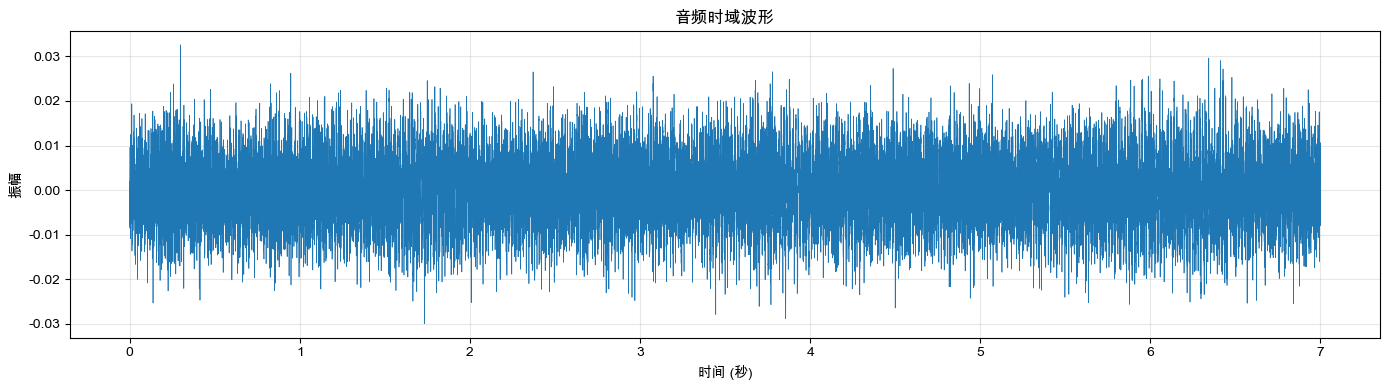

最大振幅: 0.0326
RMS: 0.0074


In [20]:
# 绘制时域波形
time_axis = np.arange(len(audio_data)) / SAMPLE_RATE

plt.figure(figsize=(14, 4))
plt.plot(time_axis, audio_data, linewidth=0.5)
plt.xlabel('时间 (秒)')
plt.ylabel('振幅')
plt.title('音频时域波形')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 显示统计信息
print(f"最大振幅: {np.max(np.abs(audio_data)):.4f}")
print(f"RMS: {np.sqrt(np.mean(audio_data**2)):.4f}")

## 6. 频域分析 (FFT)

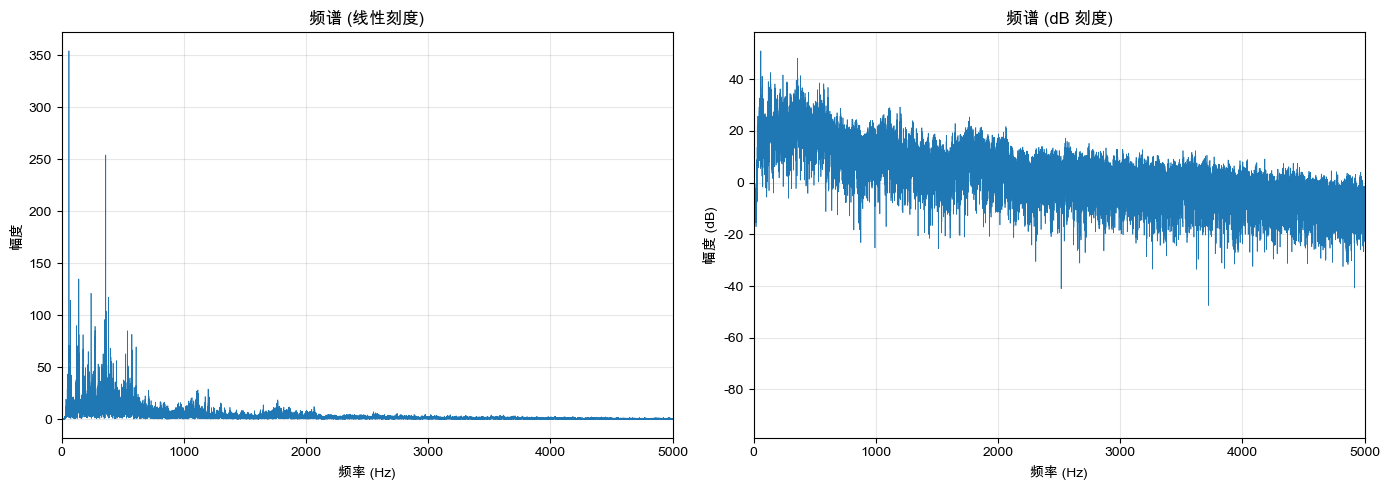


主要频率成分 (前10个):
1. 58.86 Hz, 50.98 dB
2. 360.00 Hz, 48.10 dB
3. 139.57 Hz, 42.60 dB
4. 240.00 Hz, 41.67 dB
5. 384.00 Hz, 41.39 dB
6. 69.86 Hz, 41.16 dB
7. 349.14 Hz, 39.62 dB
8. 120.00 Hz, 39.09 dB
9. 272.71 Hz, 39.02 dB
10. 538.86 Hz, 38.60 dB


In [21]:
# 计算 FFT
fft_data = fft(audio_data)
fft_freq = fftfreq(len(audio_data), 1/SAMPLE_RATE)

# 只取正频率部分
positive_freq_idx = fft_freq >= 0
fft_magnitude = np.abs(fft_data[positive_freq_idx])
fft_freq_positive = fft_freq[positive_freq_idx]

# 转换为 dB
fft_magnitude_db = 20 * np.log10(fft_magnitude + 1e-10)

# 绘制频谱
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(fft_freq_positive, fft_magnitude, linewidth=0.5)
plt.xlabel('频率 (Hz)')
plt.ylabel('幅度')
plt.title('频谱 (线性刻度)')
plt.xlim(0, 5000)  # 只显示 0-5kHz
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(fft_freq_positive, fft_magnitude_db, linewidth=0.5)
plt.xlabel('频率 (Hz)')
plt.ylabel('幅度 (dB)')
plt.title('频谱 (dB 刻度)')
plt.xlim(0, 5000)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 找出主要频率成分
peak_indices = signal.find_peaks(fft_magnitude_db, height=-20, distance=50)[0]
peak_freqs = fft_freq_positive[peak_indices]
peak_mags = fft_magnitude_db[peak_indices]

print("\n主要频率成分 (前10个):")
sorted_indices = np.argsort(peak_mags)[::-1][:10]
for i, idx in enumerate(sorted_indices, 1):
    print(f"{i}. {peak_freqs[idx]:.2f} Hz, {peak_mags[idx]:.2f} dB")

## 7. 时频谱分析 (STFT - 短时傅里叶变换)

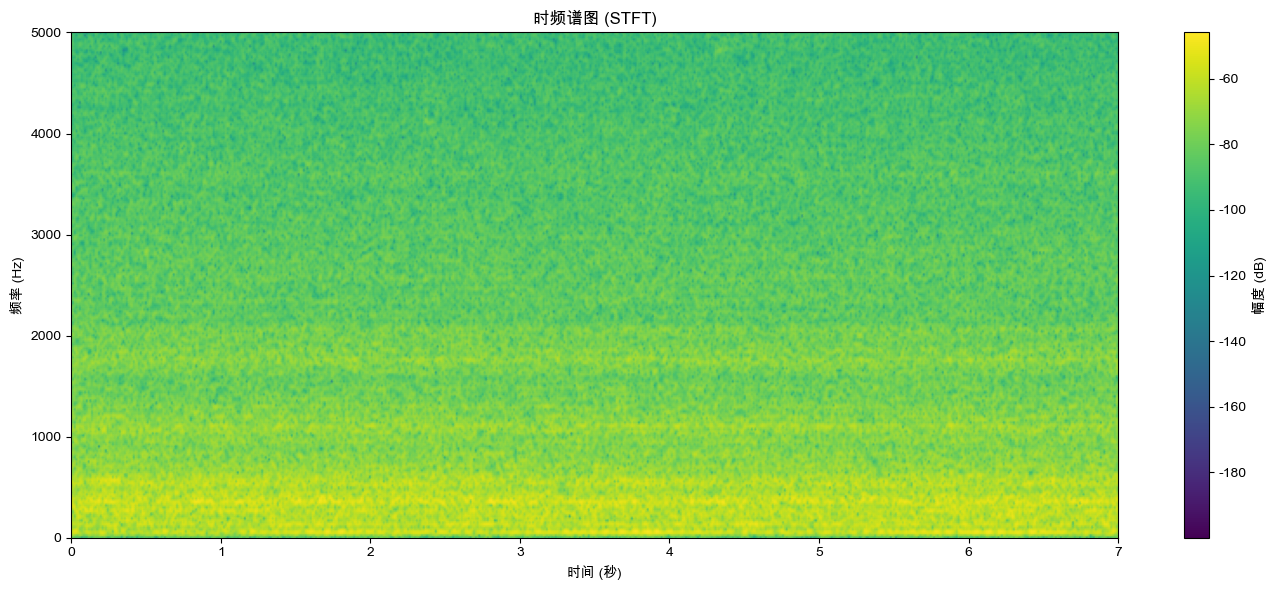

In [22]:
# 计算 STFT
f, t, Zxx = signal.stft(audio_data, 
                        fs=SAMPLE_RATE, 
                        window='hann',
                        nperseg=WINDOW_SIZE,
                        noverlap=WINDOW_SIZE - HOP_LENGTH)

# 转换为 dB
Zxx_magnitude = np.abs(Zxx)
Zxx_db = 20 * np.log10(Zxx_magnitude + 1e-10)

# 绘制时频谱图
plt.figure(figsize=(14, 6))
plt.pcolormesh(t, f, Zxx_db, shading='gouraud', cmap='viridis')
plt.colorbar(label='幅度 (dB)')
plt.ylabel('频率 (Hz)')
plt.xlabel('时间 (秒)')
plt.title('时频谱图 (STFT)')
plt.ylim(0, 5000)  # 只显示 0-5kHz
plt.tight_layout()
plt.show()

## 8. Mel 频谱图

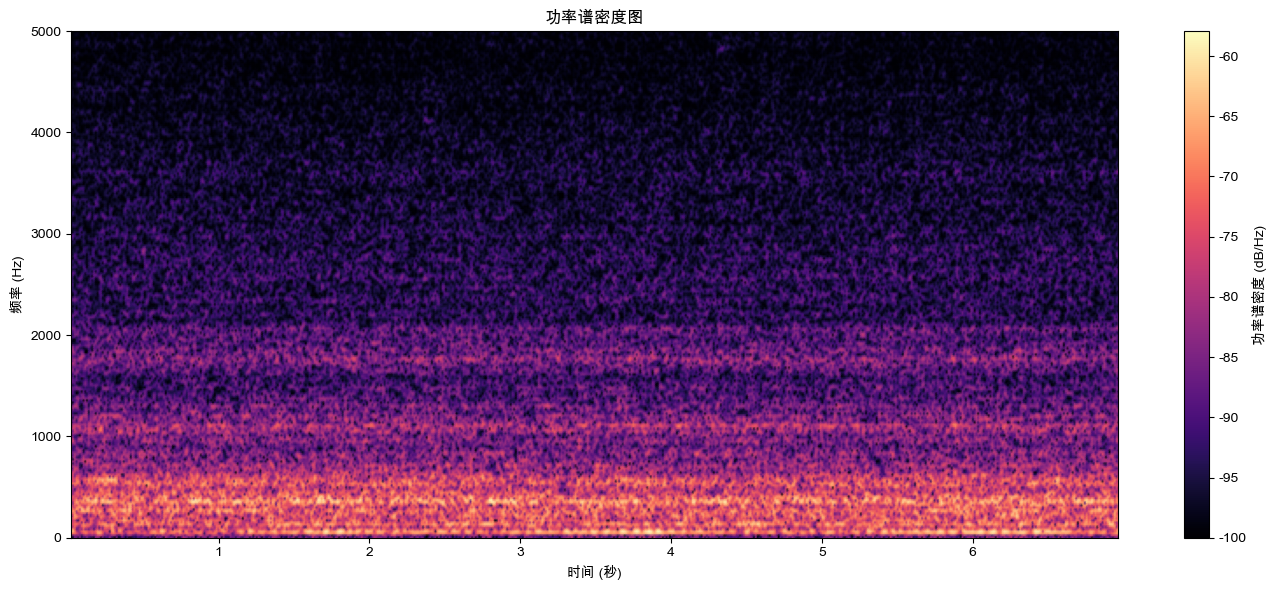

In [23]:
from scipy.signal import spectrogram

# 计算功率谱密度
frequencies, times, Sxx = spectrogram(audio_data, 
                                       fs=SAMPLE_RATE,
                                       window='hann',
                                       nperseg=WINDOW_SIZE,
                                       noverlap=WINDOW_SIZE - HOP_LENGTH)

# 转换为 dB
Sxx_db = 10 * np.log10(Sxx + 1e-10)

plt.figure(figsize=(14, 6))
plt.pcolormesh(times, frequencies, Sxx_db, shading='gouraud', cmap='magma')
plt.colorbar(label='功率谱密度 (dB/Hz)')
plt.ylabel('频率 (Hz)')
plt.xlabel('时间 (秒)')
plt.title('功率谱密度图')
plt.ylim(0, 5000)
plt.tight_layout()
plt.show()

## 9. 实时录音与分析 (流式处理)

In [29]:
# 实时录音和显示 - 优化版
class RealtimeAudioAnalyzer:
    def __init__(self, sample_rate=44100, chunk_size=1024, buffer_duration=2, device=None):
        self.sample_rate = sample_rate
        self.chunk_size = chunk_size
        self.buffer_size = int(buffer_duration * sample_rate)
        self.audio_buffer = np.zeros(self.buffer_size)
        self.is_recording = False
        self.device = device
        
        # 预计算常量
        self.window = np.hanning(self.buffer_size)
        self.time_axis = np.arange(self.buffer_size) / sample_rate
        
        # FFT 预计算
        self.fft_freq = fftfreq(self.buffer_size, 1/sample_rate)
        self.positive_idx = self.fft_freq >= 0
        self.fft_freq_positive = self.fft_freq[self.positive_idx]
        
    def audio_callback(self, indata, frames, time, status):
        """音频输入回调函数"""
        if status:
            print(status)
        # 将新数据添加到缓冲区
        self.audio_buffer = np.roll(self.audio_buffer, -len(indata))
        self.audio_buffer[-len(indata):] = indata[:, 0]
    
    def start_recording(self, duration=5, update_interval=5):
        """
        开始录音
        
        参数:
            duration: 录音时长(秒)
            update_interval: 每隔多少个 chunk 更新一次图表(默认5,约每0.1秒)
        """
        self.is_recording = True
        print(f"开始实时录音 {duration} 秒...")
        print(f"更新间隔: 每 {update_interval} 个 chunk (~{update_interval*self.chunk_size/self.sample_rate:.2f}秒)")
        
        # 创建图表
        fig, axes = plt.subplots(3, 1, figsize=(14, 12))
        
        # 初始化绘图对象(复用而不是每次重建)
        line_wave, = axes[0].plot([], [], linewidth=0.5)
        axes[0].set_xlim(0, self.buffer_size / self.sample_rate)
        axes[0].set_ylim(-1, 1)
        axes[0].set_xlabel('时间 (秒)')
        axes[0].set_ylabel('振幅')
        axes[0].set_title('实时波形')
        axes[0].grid(True, alpha=0.3)
        
        line_fft, = axes[1].plot([], [], linewidth=0.5)
        axes[1].set_xlim(0, 5000)
        axes[1].set_ylim(-80, 0)
        axes[1].set_xlabel('频率 (Hz)')
        axes[1].set_ylabel('幅度 (dB)')
        axes[1].set_title('实时频谱')
        axes[1].grid(True, alpha=0.3)
        
        # Spectrogram 使用 imshow 而不是 pcolormesh(更快)
        spec_img = None
        axes[2].set_xlabel('时间 (秒)')
        axes[2].set_ylabel('频率 (Hz)')
        axes[2].set_title('实时功率谱密度图')
        
        plt.tight_layout()
        
        with sd.InputStream(callback=self.audio_callback, 
                          channels=1, 
                          samplerate=self.sample_rate,
                          blocksize=self.chunk_size,
                          device=self.device):
            
            total_chunks = int(duration * self.sample_rate / self.chunk_size)
            
            for i in range(total_chunks):
                if not self.is_recording:
                    break
                
                # 只在指定间隔更新图表
                if i % update_interval != 0:
                    continue
                
                # 更新时域波形
                line_wave.set_data(self.time_axis, self.audio_buffer)
                
                # 计算并更新频谱
                fft_data = fft(self.audio_buffer * self.window)
                fft_magnitude_db = 20 * np.log10(np.abs(fft_data[self.positive_idx]) + 1e-10)
                line_fft.set_data(self.fft_freq_positive, fft_magnitude_db)
                
                # 计算并更新频谱图(降低分辨率以提速)
                frequencies, times, Sxx = signal.spectrogram(
                    self.audio_buffer, 
                    fs=self.sample_rate,
                    window='hann',
                    nperseg=1024,  # 从2048降到1024
                    noverlap=512   # 从1536降到512
                )
                Sxx_db = 10 * np.log10(Sxx + 1e-10)
                
                # 只显示 0-5kHz
                freq_mask = frequencies <= 5000
                
                if spec_img is None:
                    spec_img = axes[2].imshow(
                        Sxx_db[freq_mask], 
                        aspect='auto',
                        origin='lower',
                        cmap='magma',
                        extent=[times[0], times[-1], frequencies[freq_mask][0], frequencies[freq_mask][-1]],
                        vmin=Sxx_db.max()-80, 
                        vmax=Sxx_db.max()
                    )
                    plt.colorbar(spec_img, ax=axes[2], label='功率谱密度 (dB/Hz)')
                else:
                    spec_img.set_data(Sxx_db[freq_mask])
                    spec_img.set_clim(vmin=Sxx_db.max()-80, vmax=Sxx_db.max())
                
                # 更新显示
                clear_output(wait=True)
                display(fig)
                plt.pause(0.01)
        
        print("录音结束!")
        self.is_recording = False
        plt.close(fig)
        return self.audio_buffer

# 创建分析器实例,使用选定的设备
analyzer = RealtimeAudioAnalyzer(sample_rate=SAMPLE_RATE, 
                                 chunk_size=CHUNK_SIZE, 
                                 device=SELECTED_DEVICE)

# 提示用户
print("准备开始实时录音和分析...")
print("运行下一个 cell 开始录音")

准备开始实时录音和分析...
运行下一个 cell 开始录音


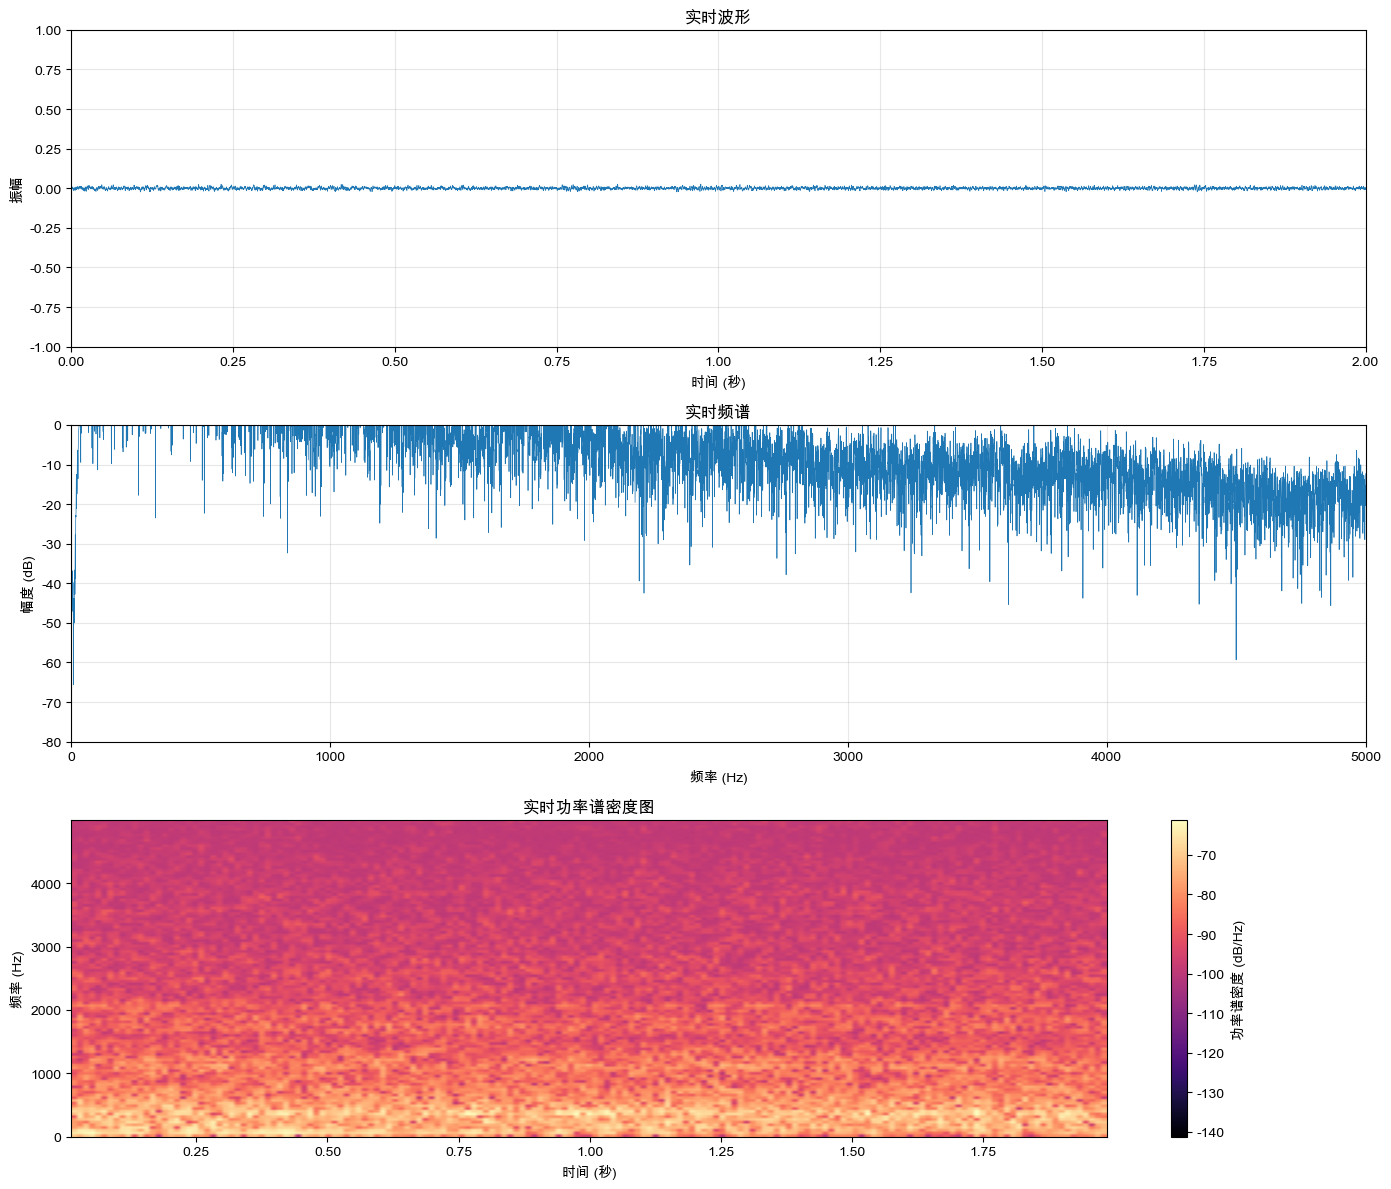

录音结束!


In [30]:
# 运行实时分析 (默认 5 秒)
recorded_audio = analyzer.start_recording(duration=5)

## 10. 保存录音

In [ ]:
from scipy.io import wavfile
import os

# 保存为 WAV 文件
output_filename = 'recorded_audio.wav'
wavfile.write(output_filename, SAMPLE_RATE, audio_data)
print(f"音频已保存到: {os.path.abspath(output_filename)}")

# 文件信息
file_size = os.path.getsize(output_filename) / 1024  # KB
print(f"文件大小: {file_size:.2f} KB")

## 11. 加载并分析已有音频文件

In [ ]:
# 加载音频文件
def load_and_analyze_audio(filename):
    """加载并分析音频文件"""
    try:
        sample_rate, data = wavfile.read(filename)
        
        # 转换为单声道
        if len(data.shape) > 1:
            data = data.mean(axis=1)
        
        # 归一化
        data = data.astype(np.float32)
        if data.max() > 1.0:
            data = data / np.iinfo(data.dtype).max
        
        print(f"文件: {filename}")
        print(f"采样率: {sample_rate} Hz")
        print(f"时长: {len(data)/sample_rate:.2f} 秒")
        print(f"样本数: {len(data)}")
        
        return sample_rate, data
    except FileNotFoundError:
        print(f"文件 {filename} 不存在")
        return None, None

# 示例: 加载刚才保存的文件
# sr, loaded_audio = load_and_analyze_audio('recorded_audio.wav')

## 12. 噪声分析 - 自相关方法

In [31]:
def extract_noise_autocorr(audio_signal, sample_rate, noise_threshold_percentile=20):
    """
    使用自相关方法提取并分析噪声成分
    
    参数:
        audio_signal: 输入音频信号
        sample_rate: 采样率
        noise_threshold_percentile: 用于判定噪声的能量百分位(默认20%,即低能量部分视为噪声)
    
    返回:
        noise_signal: 提取的噪声信号
        noise_autocorr: 噪声的自相关函数
        noise_freq_components: 噪声的主要频率成分
    """
    # 1. 计算短时能量,识别噪声段
    frame_length = 2048
    hop_length = 512
    
    # 分帧并计算能量
    num_frames = (len(audio_signal) - frame_length) // hop_length + 1
    energy = np.zeros(num_frames)
    
    for i in range(num_frames):
        start = i * hop_length
        end = start + frame_length
        frame = audio_signal[start:end]
        energy[i] = np.sum(frame ** 2) / len(frame)  # RMS能量
    
    # 2. 基于能量阈值提取噪声段
    energy_threshold = np.percentile(energy, noise_threshold_percentile)
    noise_frames = energy < energy_threshold
    
    # 3. 重建噪声信号
    noise_signal = np.zeros_like(audio_signal)
    for i in range(num_frames):
        if noise_frames[i]:
            start = i * hop_length
            end = start + frame_length
            if end <= len(noise_signal):
                noise_signal[start:end] += audio_signal[start:end]
    
    # 归一化
    noise_signal = noise_signal / (np.max(np.abs(noise_signal)) + 1e-10)
    
    # 4. 计算自相关函数
    # 使用 FFT 加速自相关计算
    noise_fft = fft(noise_signal, n=2*len(noise_signal))
    noise_autocorr = np.real(fft(noise_fft * np.conj(noise_fft))[:len(noise_signal)])
    noise_autocorr = noise_autocorr / noise_autocorr[0]  # 归一化
    
    # 5. 从自相关函数中提取周期性成分(频率峰值)
    # 对自相关函数进行 FFT 得到功率谱
    noise_power_spectrum = np.abs(fft(noise_autocorr))
    noise_freq = fftfreq(len(noise_autocorr), 1/sample_rate)
    
    # 只取正频率部分
    positive_idx = noise_freq >= 0
    noise_power_spectrum_positive = noise_power_spectrum[positive_idx]
    noise_freq_positive = noise_freq[positive_idx]
    
    # 转换为 dB
    noise_power_db = 20 * np.log10(noise_power_spectrum_positive + 1e-10)
    
    # 找出主要频率峰值
    peak_indices = signal.find_peaks(noise_power_db, 
                                     height=noise_power_db.max() - 40,  # 相对阈值 40dB
                                     distance=20)[0]
    
    noise_freq_components = {
        'frequencies': noise_freq_positive[peak_indices],
        'magnitudes_db': noise_power_db[peak_indices],
        'magnitudes_linear': noise_power_spectrum_positive[peak_indices]
    }
    
    return noise_signal, noise_autocorr, noise_freq_components, energy, energy_threshold


# 对录制的音频进行噪声分析
print("正在分析噪声成分...")
noise_signal, noise_autocorr, noise_components, energy, threshold = extract_noise_autocorr(
    audio_data, 
    SAMPLE_RATE, 
    noise_threshold_percentile=20  # 将能量最低的20%视为噪声
)

print(f"\n噪声提取完成!")
print(f"噪声信号时长: {len(noise_signal)/SAMPLE_RATE:.2f} 秒")
print(f"噪声占比: {(np.sum(np.abs(noise_signal) > 0.01) / len(noise_signal) * 100):.2f}%")


正在分析噪声成分...

噪声提取完成!
噪声信号时长: 7.00 秒
噪声占比: 35.64%


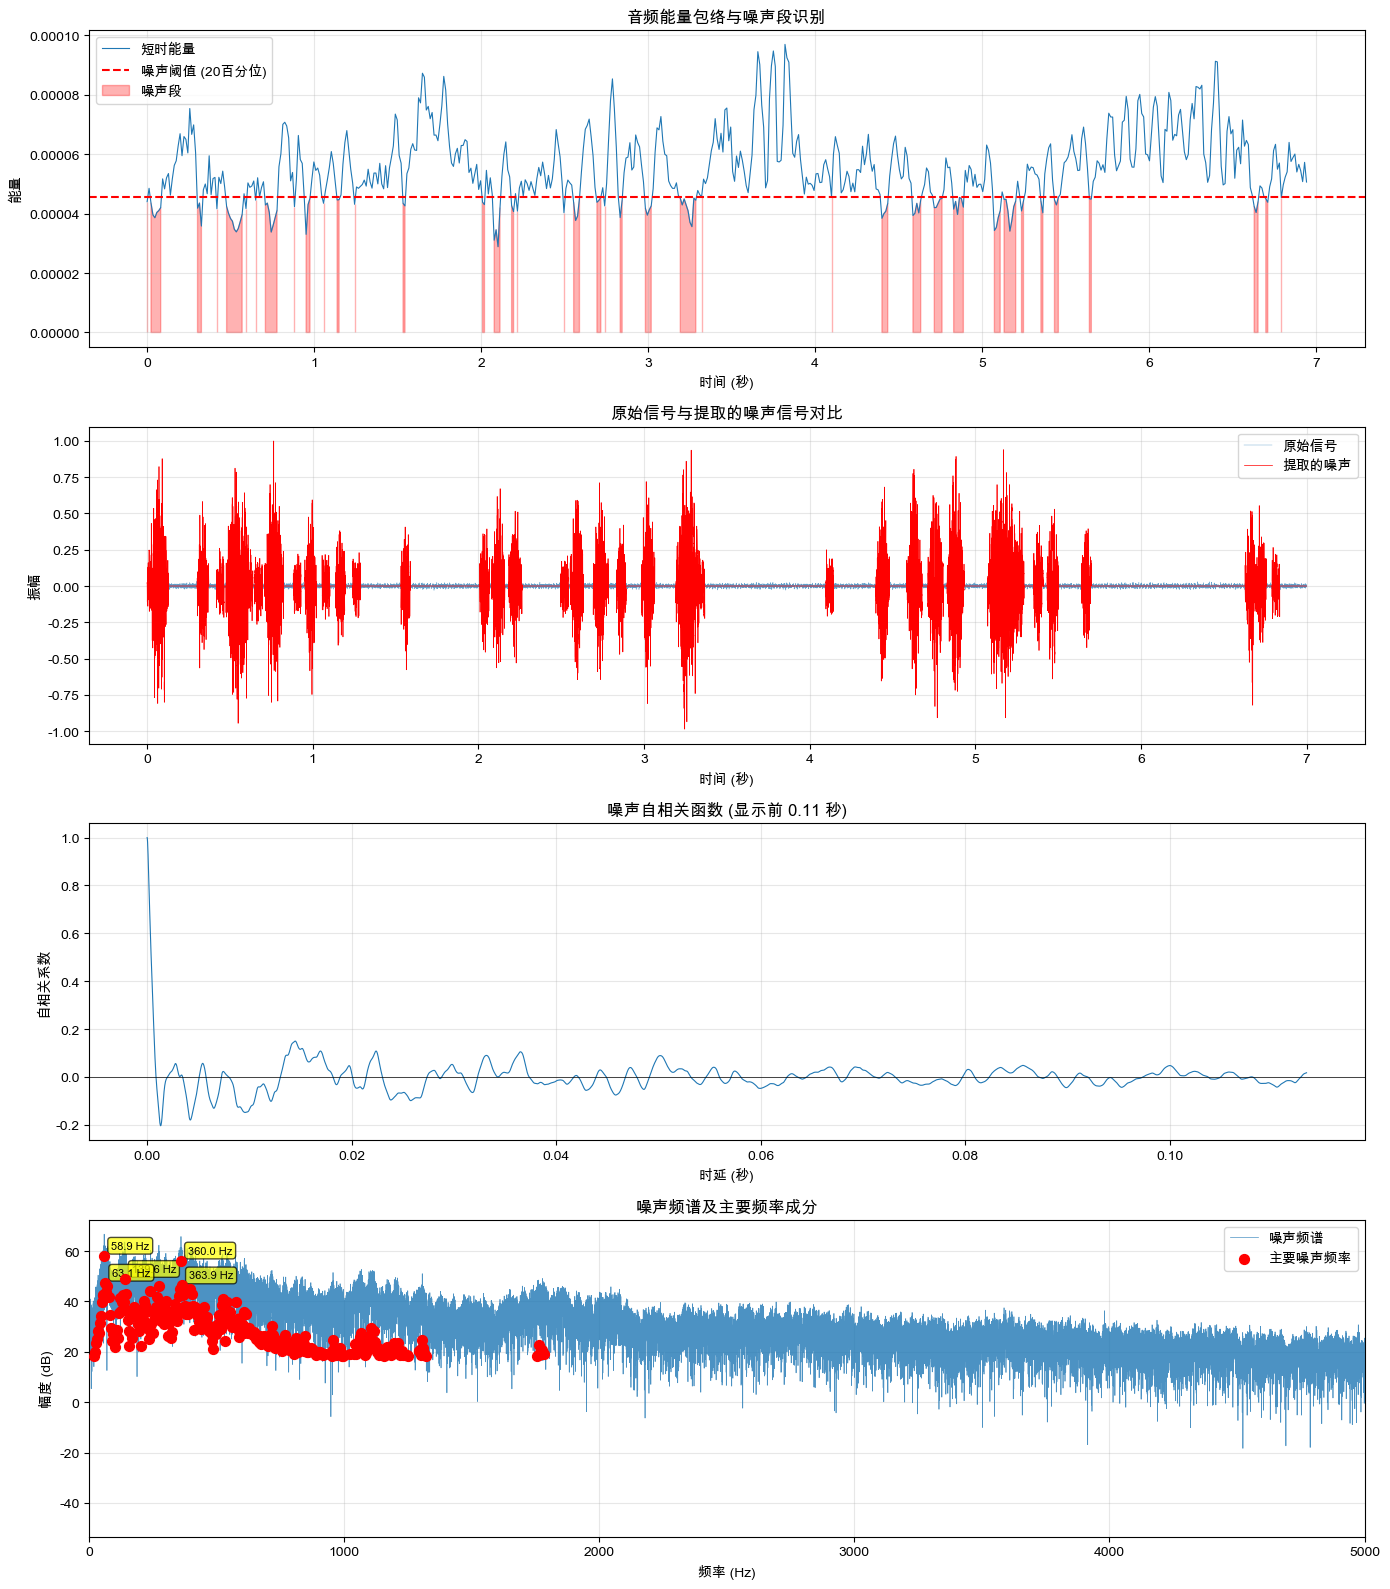


噪声的主要频率成分 (按幅度排序):
 1.    58.86 Hz,   58.14 dB
 2.   360.00 Hz,   56.23 dB
 3.   139.57 Hz,   48.93 dB
 4.    63.14 Hz,   47.43 dB
 5.   363.86 Hz,   46.36 dB
 6.   273.43 Hz,   46.12 dB
 7.    71.43 Hz,   46.09 dB
 8.   396.86 Hz,   45.01 dB
 9.   356.71 Hz,   44.73 dB
10.   240.00 Hz,   44.19 dB
11.   384.00 Hz,   43.82 dB
12.    67.29 Hz,   43.66 dB
13.   402.14 Hz,   43.14 dB
14.   142.86 Hz,   43.05 dB
15.   368.00 Hz,   42.67 dB


In [32]:
# 可视化噪声分析结果
fig, axes = plt.subplots(4, 1, figsize=(14, 16))

# 1. 能量包络与噪声阈值
time_frames = np.arange(len(energy)) * 512 / SAMPLE_RATE
axes[0].plot(time_frames, energy, linewidth=0.8, label='短时能量')
axes[0].axhline(y=threshold, color='r', linestyle='--', linewidth=1.5, label=f'噪声阈值 (20百分位)')
axes[0].fill_between(time_frames, 0, energy, where=(energy < threshold), 
                     alpha=0.3, color='red', label='噪声段')
axes[0].set_xlabel('时间 (秒)')
axes[0].set_ylabel('能量')
axes[0].set_title('音频能量包络与噪声段识别')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. 原始信号 vs 噪声信号对比
time_axis_full = np.arange(len(audio_data)) / SAMPLE_RATE
axes[1].plot(time_axis_full, audio_data, linewidth=0.3, alpha=0.7, label='原始信号')
axes[1].plot(time_axis_full, noise_signal, linewidth=0.5, color='red', label='提取的噪声')
axes[1].set_xlabel('时间 (秒)')
axes[1].set_ylabel('振幅')
axes[1].set_title('原始信号与提取的噪声信号对比')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. 噪声的自相关函数
lag_axis = np.arange(len(noise_autocorr)) / SAMPLE_RATE
axes[2].plot(lag_axis[:5000], noise_autocorr[:5000], linewidth=0.8)  # 只显示前5000个点
axes[2].set_xlabel('时延 (秒)')
axes[2].set_ylabel('自相关系数')
axes[2].set_title('噪声自相关函数 (显示前 0.11 秒)')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=0, color='k', linestyle='-', linewidth=0.5)

# 4. 噪声频谱
noise_fft_full = fft(noise_signal)
noise_freq_full = fftfreq(len(noise_signal), 1/SAMPLE_RATE)
positive_idx = noise_freq_full >= 0
noise_magnitude_db = 20 * np.log10(np.abs(noise_fft_full[positive_idx]) + 1e-10)

axes[3].plot(noise_freq_full[positive_idx], noise_magnitude_db, 
            linewidth=0.5, alpha=0.8, label='噪声频谱')

# 标注主要频率成分
if len(noise_components['frequencies']) > 0:
    axes[3].scatter(noise_components['frequencies'], 
                   noise_components['magnitudes_db'],
                   color='red', s=50, zorder=5, label='主要噪声频率')
    
    # 标注前5个最强的频率
    sorted_indices = np.argsort(noise_components['magnitudes_db'])[::-1][:5]
    for idx in sorted_indices:
        freq = noise_components['frequencies'][idx]
        mag = noise_components['magnitudes_db'][idx]
        axes[3].annotate(f'{freq:.1f} Hz', 
                        xy=(freq, mag), 
                        xytext=(5, 5), 
                        textcoords='offset points',
                        fontsize=8,
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

axes[3].set_xlabel('频率 (Hz)')
axes[3].set_ylabel('幅度 (dB)')
axes[3].set_title('噪声频谱及主要频率成分')
axes[3].set_xlim(0, 5000)
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 输出噪声的主要频率成分
print("\n噪声的主要频率成分 (按幅度排序):")
if len(noise_components['frequencies']) > 0:
    sorted_indices = np.argsort(noise_components['magnitudes_db'])[::-1]
    for i, idx in enumerate(sorted_indices[:15], 1):  # 显示前15个
        freq = noise_components['frequencies'][idx]
        mag_db = noise_components['magnitudes_db'][idx]
        print(f"{i:2d}. {freq:8.2f} Hz, {mag_db:7.2f} dB")
else:
    print("未检测到明显的噪声频率成分")


## 13. 计算噪声成分的波长(室温20°C)

In [33]:
# 计算噪声主要频率成分的波长
# 声速计算: v = 331.3 + 0.606 * T (m/s), 其中 T 是摄氏温度
TEMPERATURE = 20  # 摄氏度
sound_speed = 331.3 + 0.606 * TEMPERATURE  # 声速 (m/s)

print(f"环境温度: {TEMPERATURE}°C")
print(f"声速: {sound_speed:.2f} m/s")
print("\n噪声主要频率成分及其对应波长:")
print("=" * 70)
print(f"{'序号':<6} {'频率 (Hz)':<12} {'幅度 (dB)':<12} {'波长 (m)':<12} {'波长 (cm)':<12}")
print("=" * 70)

if len(noise_components['frequencies']) > 0:
    # 按幅度排序
    sorted_indices = np.argsort(noise_components['magnitudes_db'])[::-1]
    
    wavelengths_m = []
    wavelengths_cm = []
    frequencies_sorted = []
    
    for i, idx in enumerate(sorted_indices[:15], 1):  # 显示前15个
        freq = noise_components['frequencies'][idx]
        mag_db = noise_components['magnitudes_db'][idx]
        
        # 计算波长: λ = v / f
        wavelength_m = sound_speed / freq
        wavelength_cm = wavelength_m * 100
        
        wavelengths_m.append(wavelength_m)
        wavelengths_cm.append(wavelength_cm)
        frequencies_sorted.append(freq)
        
        print(f"{i:<6} {freq:<12.2f} {mag_db:<12.2f} {wavelength_m:<12.4f} {wavelength_cm:<12.2f}")
    
    print("=" * 70)
    
    # 统计信息
    print(f"\n波长范围: {min(wavelengths_cm):.2f} cm ~ {max(wavelengths_cm):.2f} cm")
    print(f"          ({min(wavelengths_m):.4f} m ~ {max(wavelengths_m):.4f} m)")
    print(f"\n频率范围: {min(frequencies_sorted):.2f} Hz ~ {max(frequencies_sorted):.2f} Hz")
    
else:
    print("未检测到明显的噪声频率成分")

环境温度: 20°C
声速: 343.42 m/s

噪声主要频率成分及其对应波长:
序号     频率 (Hz)      幅度 (dB)      波长 (m)       波长 (cm)     
1      58.86        58.14        5.8348       583.48      
2      360.00       56.23        0.9539       95.39       
3      139.57       48.93        2.4605       246.05      
4      63.14        47.43        5.4388       543.88      
5      363.86       46.36        0.9438       94.38       
6      273.43       46.12        1.2560       125.60      
7      71.43        46.09        4.8079       480.79      
8      396.86       45.01        0.8653       86.53       
9      356.71       44.73        0.9627       96.27       
10     240.00       44.19        1.4309       143.09      
11     384.00       43.82        0.8943       89.43       
12     67.29        43.66        5.1039       510.39      
13     402.14       43.14        0.8540       85.40       
14     142.86       43.05        2.4039       240.39      
15     368.00       42.67        0.9332       93.32       

波长范围: 85.40 

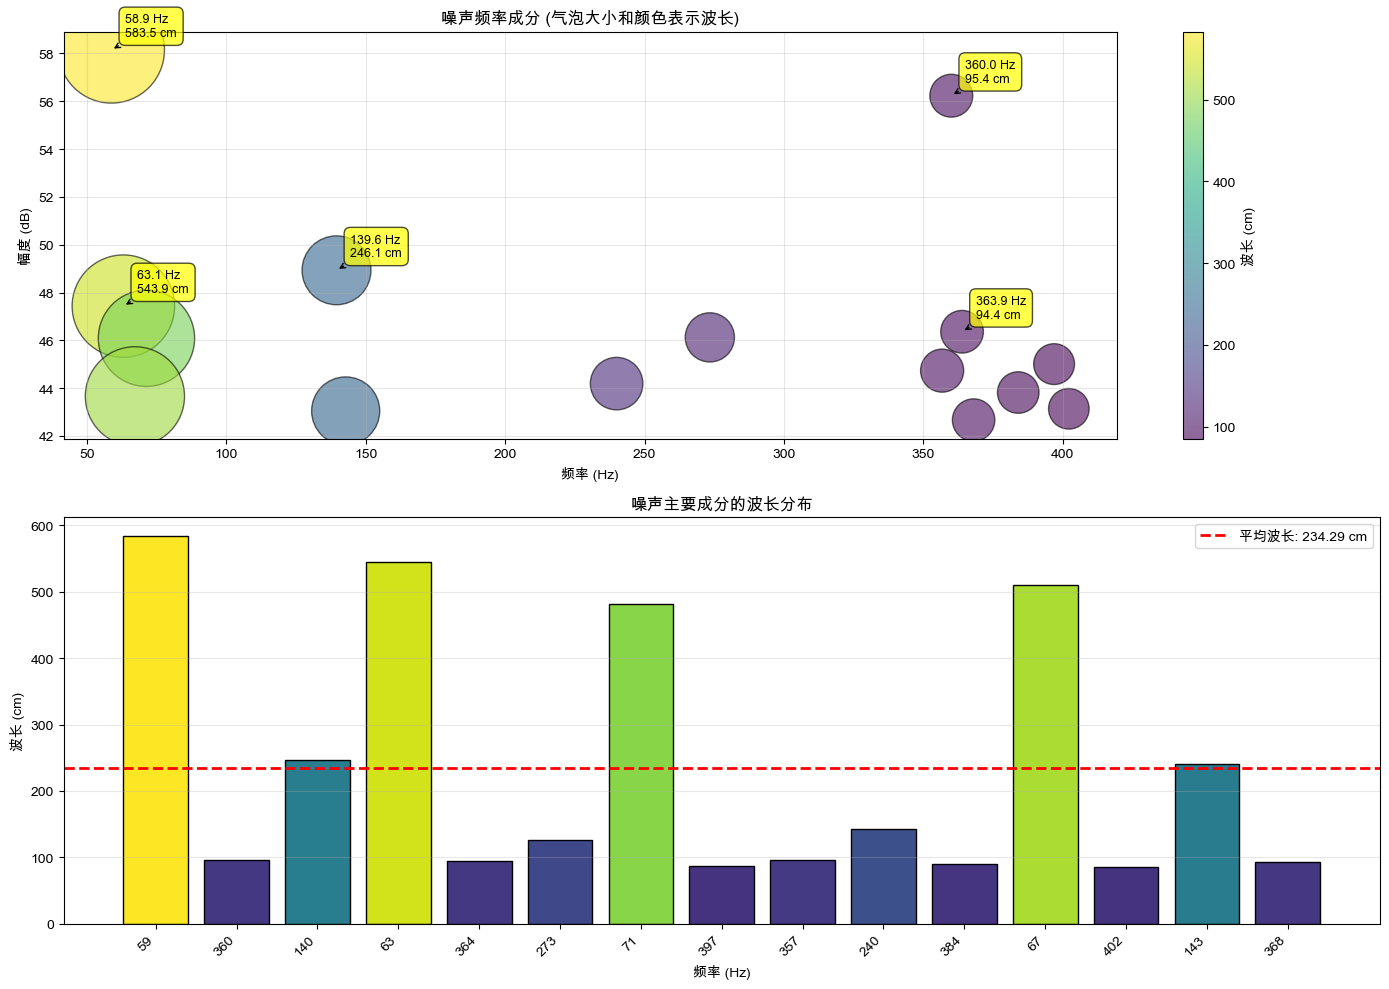

In [34]:
# 可视化频率-波长关系
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

if len(noise_components['frequencies']) > 0:
    sorted_indices = np.argsort(noise_components['magnitudes_db'])[::-1][:15]
    
    freqs = noise_components['frequencies'][sorted_indices]
    mags = noise_components['magnitudes_db'][sorted_indices]
    wavelengths = sound_speed / freqs * 100  # 转换为 cm
    
    # 图1: 频率 vs 幅度,气泡大小表示波长
    scatter = axes[0].scatter(freqs, mags, s=wavelengths*10, 
                             c=wavelengths, cmap='viridis', 
                             alpha=0.6, edgecolors='black', linewidth=1)
    
    # 标注前5个最强的成分
    for i in range(min(5, len(freqs))):
        axes[0].annotate(f'{freqs[i]:.1f} Hz\n{wavelengths[i]:.1f} cm', 
                        xy=(freqs[i], mags[i]), 
                        xytext=(10, 10), 
                        textcoords='offset points',
                        fontsize=9,
                        bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    axes[0].set_xlabel('频率 (Hz)')
    axes[0].set_ylabel('幅度 (dB)')
    axes[0].set_title('噪声频率成分 (气泡大小和颜色表示波长)')
    axes[0].grid(True, alpha=0.3)
    
    cbar = plt.colorbar(scatter, ax=axes[0])
    cbar.set_label('波长 (cm)')
    
    # 图2: 波长分布
    axes[1].bar(range(len(wavelengths)), wavelengths, 
               color=plt.cm.viridis(wavelengths/wavelengths.max()),
               edgecolor='black', linewidth=1)
    axes[1].set_xlabel('噪声成分序号 (按幅度排序)')
    axes[1].set_ylabel('波长 (cm)')
    axes[1].set_title('噪声主要成分的波长分布')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # 添加频率标签
    axes[1].set_xticks(range(len(wavelengths)))
    axes[1].set_xticklabels([f'{f:.0f}' for f in freqs], rotation=45, ha='right')
    axes[1].set_xlabel('频率 (Hz)')
    
    # 添加平均波长线
    mean_wavelength = np.mean(wavelengths)
    axes[1].axhline(y=mean_wavelength, color='r', linestyle='--', 
                   linewidth=2, label=f'平均波长: {mean_wavelength:.2f} cm')
    axes[1].legend()
    
else:
    axes[0].text(0.5, 0.5, '未检测到明显的噪声频率成分', 
                ha='center', va='center', transform=axes[0].transAxes, fontsize=14)
    axes[1].text(0.5, 0.5, '未检测到明显的噪声频率成分', 
                ha='center', va='center', transform=axes[1].transAxes, fontsize=14)

plt.tight_layout()
plt.show()

## 14. 房间内噪声传播模拟

In [35]:
def calculate_noise_level_in_room(source_frequencies, source_magnitudes_db, 
                                  room_dimensions, wall_absorption=0.4,
                                  source_positions=None, grid_resolution=0.5):
    """
    计算房间内不同噪声源位置下的平均噪声水平
    
    参数:
        source_frequencies: 噪声源的频率成分 (Hz)
        source_magnitudes_db: 各频率成分的幅度 (dB)
        room_dimensions: 房间尺寸 (长, 宽, 高) 单位:米
        wall_absorption: 墙壁吸收系数 (0-1, 0表示完全反射, 1表示完全吸收)
        source_positions: 噪声源位置列表 [(x1,y1,z1), (x2,y2,z2), ...], 
                         如果为None则自动在地面网格采样
        grid_resolution: 接收点网格分辨率 (米)
    
    返回:
        results: 包含各噪声源位置的分析结果
    """
    length, width, height = room_dimensions
    
    # 如果未指定源位置,在地面(z=0)上均匀采样
    if source_positions is None:
        source_x = np.linspace(1, length-1, 5)  # 避免太靠近墙壁
        source_y = np.linspace(1, width-1, 3)
        source_positions = [(x, y, 0.5) for x in source_x for y in source_y]  # 地面上方0.5m
    
    # 创建接收点网格(覆盖整个房间空间)
    x_receivers = np.arange(0, length, grid_resolution)
    y_receivers = np.arange(0, width, grid_resolution)
    z_receivers = np.arange(0.5, height, grid_resolution)  # 从0.5m到天花板
    
    results = []
    
    for source_pos in source_positions:
        xs, ys, zs = source_pos
        
        # 存储每个接收点的声压级
        spl_grid = np.zeros((len(x_receivers), len(y_receivers), len(z_receivers)))
        
        for i, x in enumerate(x_receivers):
            for j, y in enumerate(y_receivers):
                for k, z in enumerate(z_receivers):
                    # 计算直达声距离
                    direct_distance = np.sqrt((x - xs)**2 + (y - ys)**2 + (z - zs)**2)
                    
                    # 避免除零
                    if direct_distance < 0.1:
                        direct_distance = 0.1
                    
                    # 简化的房间声学模型:
                    # 1. 直达声衰减: 按距离平方反比衰减
                    # 2. 反射声: 考虑一次墙面反射的贡献
                    
                    # 直达声衰减 (dB)
                    # SPL = SPL0 - 20*log10(r/r0), 取r0=1m
                    direct_attenuation = 20 * np.log10(direct_distance)
                    
                    # 计算主要墙面的反射路径(简化为6个主要反射)
                    reflection_distances = []
                    
                    # 地面反射
                    mirror_z = -zs
                    d_floor = np.sqrt((x - xs)**2 + (y - ys)**2 + (z - mirror_z)**2)
                    reflection_distances.append(d_floor)
                    
                    # 天花板反射
                    mirror_z = 2*height - zs
                    d_ceiling = np.sqrt((x - xs)**2 + (y - ys)**2 + (z - mirror_z)**2)
                    reflection_distances.append(d_ceiling)
                    
                    # 左右墙反射
                    mirror_y = -ys
                    d_wall1 = np.sqrt((x - xs)**2 + (y - mirror_y)**2 + (z - zs)**2)
                    reflection_distances.append(d_wall1)
                    
                    mirror_y = 2*width - ys
                    d_wall2 = np.sqrt((x - xs)**2 + (y - mirror_y)**2 + (z - zs)**2)
                    reflection_distances.append(d_wall2)
                    
                    # 前后墙反射
                    mirror_x = -xs
                    d_wall3 = np.sqrt((x - mirror_x)**2 + (y - ys)**2 + (z - zs)**2)
                    reflection_distances.append(d_wall3)
                    
                    mirror_x = 2*length - xs
                    d_wall4 = np.sqrt((x - mirror_x)**2 + (y - ys)**2 + (z - zs)**2)
                    reflection_distances.append(d_wall4)
                    
                    # 计算总声压级(能量叠加)
                    # 将dB转换为线性功率,累加后再转回dB
                    total_power = 0
                    
                    for freq_idx, (freq, mag_db) in enumerate(zip(source_frequencies, source_magnitudes_db)):
                        # 参考声压级(源的幅度)
                        source_power = 10 ** (mag_db / 10)
                        
                        # 直达声功率
                        direct_power = source_power * (1 / direct_distance**2)
                        total_power += direct_power
                        
                        # 反射声功率(考虑墙壁吸收)
                        reflection_coefficient = 1 - wall_absorption
                        for ref_dist in reflection_distances:
                            if ref_dist > 0.1:
                                reflection_power = source_power * (reflection_coefficient / ref_dist**2)
                                total_power += reflection_power
                    
                    # 转换回dB
                    if total_power > 0:
                        spl_grid[i, j, k] = 10 * np.log10(total_power)
                    else:
                        spl_grid[i, j, k] = -np.inf
        
        # 计算统计量
        valid_spl = spl_grid[np.isfinite(spl_grid)]
        
        result = {
            'source_position': source_pos,
            'spl_grid': spl_grid,
            'mean_spl': np.mean(valid_spl),
            'max_spl': np.max(valid_spl),
            'min_spl': np.min(valid_spl),
            'std_spl': np.std(valid_spl),
            'x_receivers': x_receivers,
            'y_receivers': y_receivers,
            'z_receivers': z_receivers
        }
        
        results.append(result)
    
    return results


# 使用实测噪声数据进行房间声学模拟
ROOM_DIMENSIONS = (8, 4, 2.5)  # 长8m, 宽4m, 高2.5m
WALL_ABSORPTION = 0.4  # 墙壁吸收系数

print("=" * 70)
print("房间声学模拟参数")
print("=" * 70)
print(f"房间尺寸: {ROOM_DIMENSIONS[0]}m × {ROOM_DIMENSIONS[1]}m × {ROOM_DIMENSIONS[2]}m")
print(f"房间体积: {ROOM_DIMENSIONS[0] * ROOM_DIMENSIONS[1] * ROOM_DIMENSIONS[2]:.1f} m³")
print(f"墙壁吸收系数: {WALL_ABSORPTION}")
print(f"墙壁反射系数: {1 - WALL_ABSORPTION}")
print("=" * 70)

# 提取噪声的主要频率成分(前10个最强的)
if len(noise_components['frequencies']) > 0:
    sorted_indices = np.argsort(noise_components['magnitudes_db'])[::-1][:10]
    selected_freqs = noise_components['frequencies'][sorted_indices]
    selected_mags = noise_components['magnitudes_db'][sorted_indices]
    
    print(f"\n使用的噪声频率成分 (前10个):")
    for i, (f, m) in enumerate(zip(selected_freqs, selected_mags), 1):
        print(f"  {i:2d}. {f:8.2f} Hz, {m:7.2f} dB")
    
    print("\n开始计算房间内噪声分布...")
    print("(这可能需要一些时间...)")
    
    # 计算不同源位置的噪声分布
    room_results = calculate_noise_level_in_room(
        source_frequencies=selected_freqs,
        source_magnitudes_db=selected_mags,
        room_dimensions=ROOM_DIMENSIONS,
        wall_absorption=WALL_ABSORPTION,
        source_positions=None,  # 自动采样地面位置
        grid_resolution=0.5  # 0.5m网格
    )
    
    print(f"\n完成! 共分析了 {len(room_results)} 个噪声源位置")
    
else:
    print("\n错误: 未检测到噪声频率成分,无法进行模拟")
    room_results = []

房间声学模拟参数
房间尺寸: 8m × 4m × 2.5m
房间体积: 80.0 m³
墙壁吸收系数: 0.4
墙壁反射系数: 0.6

使用的噪声频率成分 (前10个):
   1.    58.86 Hz,   58.14 dB
   2.   360.00 Hz,   56.23 dB
   3.   139.57 Hz,   48.93 dB
   4.    63.14 Hz,   47.43 dB
   5.   363.86 Hz,   46.36 dB
   6.   273.43 Hz,   46.12 dB
   7.    71.43 Hz,   46.09 dB
   8.   396.86 Hz,   45.01 dB
   9.   356.71 Hz,   44.73 dB
  10.   240.00 Hz,   44.19 dB

开始计算房间内噪声分布...
(这可能需要一些时间...)

完成! 共分析了 15 个噪声源位置


In [36]:
# 分析和可视化结果
if len(room_results) > 0:
    print("\n" + "=" * 70)
    print("各噪声源位置的房间平均噪声水平")
    print("=" * 70)
    print(f"{'序号':<6} {'源位置(x,y,z)':<20} {'平均SPL':<12} {'最大SPL':<12} {'最小SPL':<12} {'标准差':<10}")
    print("=" * 70)
    
    all_mean_spls = []
    all_source_positions = []
    
    for i, result in enumerate(room_results, 1):
        pos = result['source_position']
        mean_spl = result['mean_spl']
        max_spl = result['max_spl']
        min_spl = result['min_spl']
        std_spl = result['std_spl']
        
        all_mean_spls.append(mean_spl)
        all_source_positions.append(pos)
        
        print(f"{i:<6} ({pos[0]:.1f},{pos[1]:.1f},{pos[2]:.1f})m{'':<7} "
              f"{mean_spl:<12.2f} {max_spl:<12.2f} {min_spl:<12.2f} {std_spl:<10.2f}")
    
    print("=" * 70)
    
    # 总体统计
    overall_mean = np.mean(all_mean_spls)
    overall_std = np.std(all_mean_spls)
    best_idx = np.argmax(all_mean_spls)
    worst_idx = np.argmin(all_mean_spls)
    
    print(f"\n整体统计:")
    print(f"  所有源位置的平均噪声水平: {overall_mean:.2f} dB")
    print(f"  标准差: {overall_std:.2f} dB")
    print(f"  范围: {min(all_mean_spls):.2f} ~ {max(all_mean_spls):.2f} dB")
    print(f"\n  最高平均噪声源位置: {all_source_positions[best_idx]} -> {all_mean_spls[best_idx]:.2f} dB")
    print(f"  最低平均噪声源位置: {all_source_positions[worst_idx]} -> {all_mean_spls[worst_idx]:.2f} dB")
    print(f"  位置差异: {all_mean_spls[best_idx] - all_mean_spls[worst_idx]:.2f} dB")
else:
    print("没有可用的模拟结果")


各噪声源位置的房间平均噪声水平
序号     源位置(x,y,z)           平均SPL        最大SPL        最小SPL        标准差       
1      (1.0,1.0,0.5)m        56.17        81.56        50.44        4.20      
2      (1.0,2.0,0.5)m        56.27        81.55        50.58        4.15      
3      (1.0,3.0,0.5)m        55.82        81.56        50.29        4.06      
4      (2.5,1.0,0.5)m        57.15        81.55        51.88        3.40      
5      (2.5,2.0,0.5)m        57.25        81.55        52.11        3.29      
6      (2.5,3.0,0.5)m        56.75        81.55        51.67        3.33      
7      (4.0,1.0,0.5)m        57.40        81.55        53.18        3.04      
8      (4.0,2.0,0.5)m        57.50        81.55        53.55        2.90      
9      (4.0,3.0,0.5)m        56.98        81.55        52.88        3.01      
10     (5.5,1.0,0.5)m        56.85        81.55        51.48        3.62      
11     (5.5,2.0,0.5)m        56.95        81.55        51.68        3.52      
12     (5.5,3.0,0.5)m        56.46  

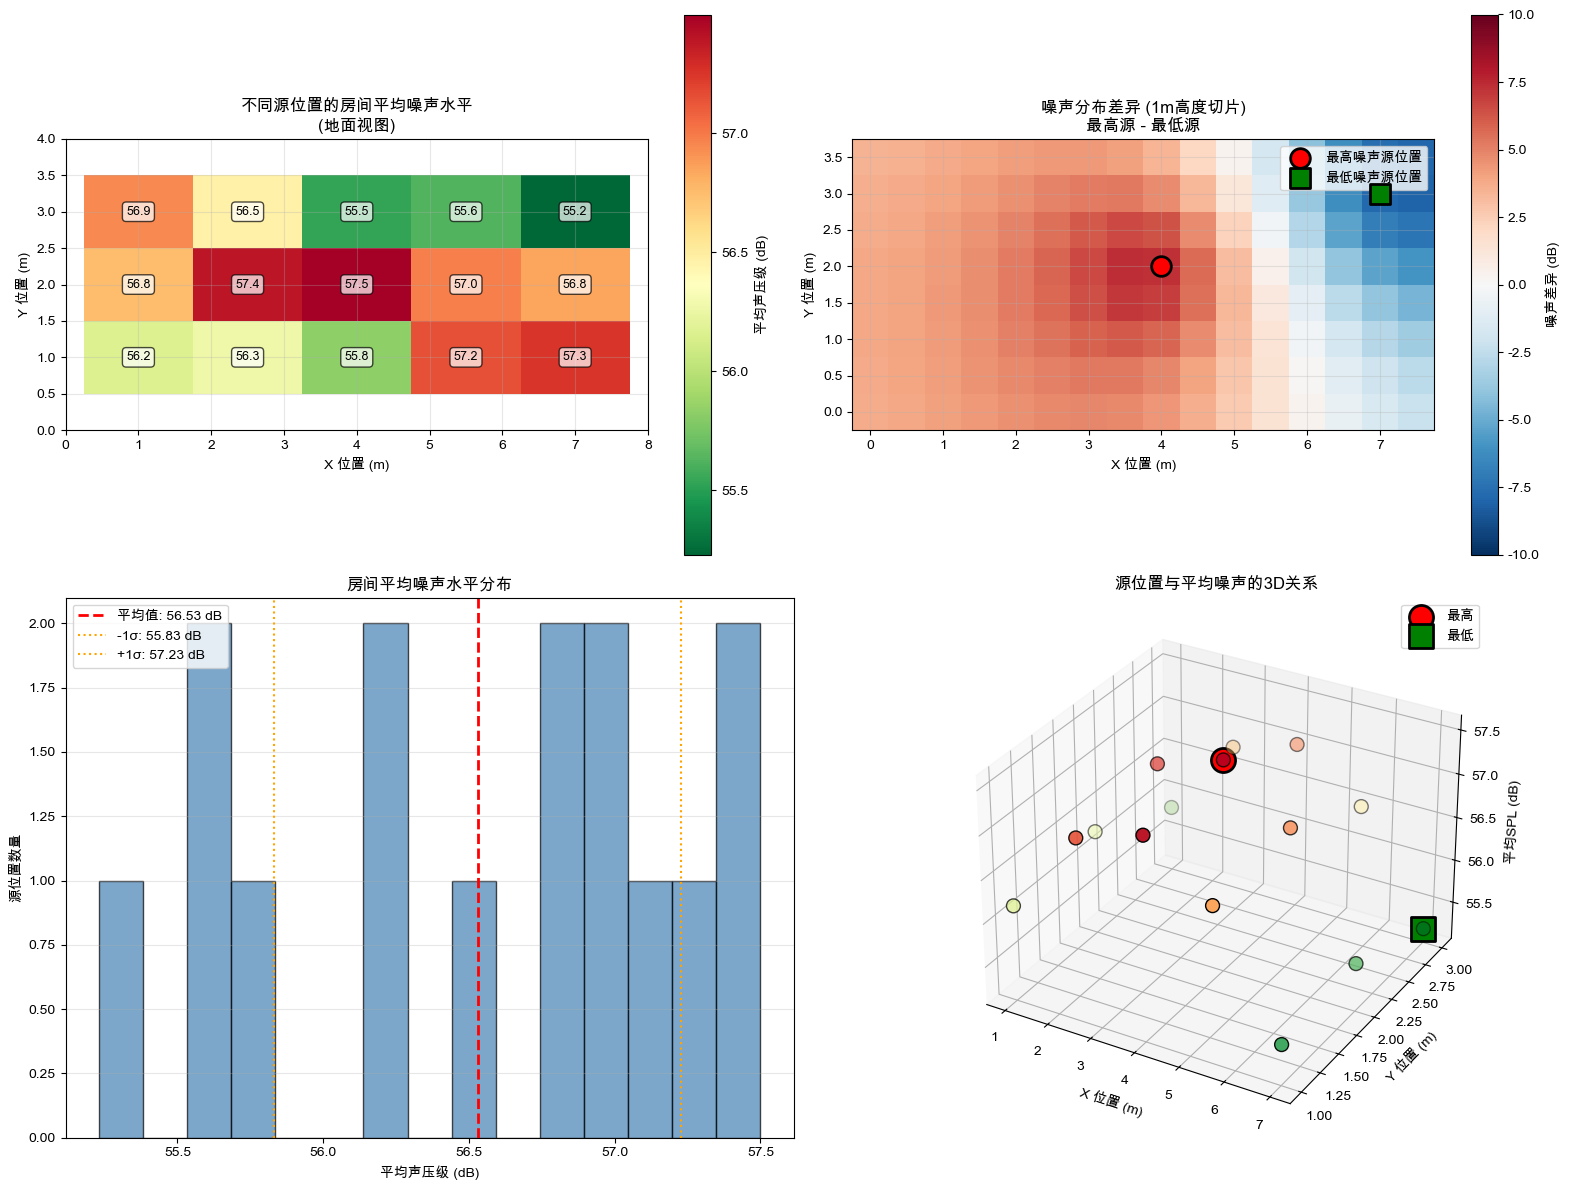


可视化说明:
  • 左上: 地面不同位置放置噪声源时,房间的平均噪声水平
  • 右上: 最高和最低噪声源位置在1m高度的噪声分布差异
  • 左下: 所有源位置的平均噪声分布直方图
  • 右下: 源位置与平均噪声的3D关系图


In [37]:
# 可视化噪声源位置对房间平均噪声的影响
if len(room_results) > 0:
    fig = plt.figure(figsize=(16, 12))
    
    # 1. 地面热力图: 源位置 vs 平均噪声水平
    ax1 = plt.subplot(2, 2, 1)
    
    # 重塑数据为网格
    source_x = np.array([pos[0] for pos in all_source_positions])
    source_y = np.array([pos[1] for pos in all_source_positions])
    
    # 创建规则网格用于插值
    unique_x = np.unique(source_x)
    unique_y = np.unique(source_y)
    
    if len(unique_x) > 1 and len(unique_y) > 1:
        grid_x, grid_y = np.meshgrid(unique_x, unique_y)
        grid_spl = np.array(all_mean_spls).reshape(len(unique_y), len(unique_x))
        
        im1 = ax1.pcolormesh(grid_x, grid_y, grid_spl, shading='auto', cmap='RdYlGn_r')
        plt.colorbar(im1, ax=ax1, label='平均声压级 (dB)')
        
        # 标注数值
        for i in range(len(unique_y)):
            for j in range(len(unique_x)):
                ax1.text(unique_x[j], unique_y[i], f'{grid_spl[i,j]:.1f}',
                        ha='center', va='center', fontsize=9, 
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    else:
        # 如果只有一行或一列,用散点图
        scatter = ax1.scatter(source_x, source_y, c=all_mean_spls, 
                            s=200, cmap='RdYlGn_r', edgecolors='black', linewidth=2)
        plt.colorbar(scatter, ax=ax1, label='平均声压级 (dB)')
    
    ax1.set_xlabel('X 位置 (m)')
    ax1.set_ylabel('Y 位置 (m)')
    ax1.set_title('不同源位置的房间平均噪声水平\n(地面视图)')
    ax1.set_xlim(0, ROOM_DIMENSIONS[0])
    ax1.set_ylim(0, ROOM_DIMENSIONS[1])
    ax1.set_aspect('equal')
    ax1.grid(True, alpha=0.3)
    
    # 2. 选择最好和最差位置的噪声分布对比(水平切片)
    ax2 = plt.subplot(2, 2, 2)
    
    best_result = room_results[best_idx]
    worst_result = room_results[worst_idx]
    
    # 取1.5m高度的水平切片
    z_slice_idx = int(1.0 / 0.5)  # 1m高度
    if z_slice_idx >= best_result['spl_grid'].shape[2]:
        z_slice_idx = best_result['spl_grid'].shape[2] - 1
    
    best_slice = best_result['spl_grid'][:, :, z_slice_idx]
    worst_slice = worst_result['spl_grid'][:, :, z_slice_idx]
    
    # 显示差异
    diff_slice = best_slice - worst_slice
    
    im2 = ax2.pcolormesh(best_result['x_receivers'], best_result['y_receivers'], 
                        diff_slice.T, shading='auto', cmap='RdBu_r', 
                        vmin=-10, vmax=10)
    plt.colorbar(im2, ax=ax2, label='噪声差异 (dB)')
    
    # 标记源位置
    ax2.scatter(*all_source_positions[best_idx][:2], s=200, marker='o', 
               color='red', edgecolors='black', linewidth=2, label='最高噪声源位置', zorder=10)
    ax2.scatter(*all_source_positions[worst_idx][:2], s=200, marker='s', 
               color='green', edgecolors='black', linewidth=2, label='最低噪声源位置', zorder=10)
    
    ax2.set_xlabel('X 位置 (m)')
    ax2.set_ylabel('Y 位置 (m)')
    ax2.set_title(f'噪声分布差异 (1m高度切片)\n最高源 - 最低源')
    ax2.legend()
    ax2.set_aspect('equal')
    ax2.grid(True, alpha=0.3)
    
    # 3. 统计分布直方图
    ax3 = plt.subplot(2, 2, 3)
    
    ax3.hist(all_mean_spls, bins=15, color='steelblue', edgecolor='black', alpha=0.7)
    ax3.axvline(overall_mean, color='red', linestyle='--', linewidth=2, label=f'平均值: {overall_mean:.2f} dB')
    ax3.axvline(overall_mean - overall_std, color='orange', linestyle=':', linewidth=1.5, label=f'-1σ: {overall_mean-overall_std:.2f} dB')
    ax3.axvline(overall_mean + overall_std, color='orange', linestyle=':', linewidth=1.5, label=f'+1σ: {overall_mean+overall_std:.2f} dB')
    
    ax3.set_xlabel('平均声压级 (dB)')
    ax3.set_ylabel('源位置数量')
    ax3.set_title('房间平均噪声水平分布')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. 3D散点图: 源位置 vs 平均噪声
    ax4 = plt.subplot(2, 2, 4, projection='3d')
    
    scatter = ax4.scatter(source_x, source_y, all_mean_spls,
                         c=all_mean_spls, s=100, cmap='RdYlGn_r', 
                         edgecolors='black', linewidth=1)
    
    # 标记最好和最差位置
    ax4.scatter(*all_source_positions[best_idx][:2], all_mean_spls[best_idx],
               s=300, marker='o', color='red', edgecolors='black', linewidth=2, 
               label='最高', zorder=10)
    ax4.scatter(*all_source_positions[worst_idx][:2], all_mean_spls[worst_idx],
               s=300, marker='s', color='green', edgecolors='black', linewidth=2, 
               label='最低', zorder=10)
    
    ax4.set_xlabel('X 位置 (m)')
    ax4.set_ylabel('Y 位置 (m)')
    ax4.set_zlabel('平均SPL (dB)')
    ax4.set_title('源位置与平均噪声的3D关系')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("\n可视化说明:")
    print("  • 左上: 地面不同位置放置噪声源时,房间的平均噪声水平")
    print("  • 右上: 最高和最低噪声源位置在1m高度的噪声分布差异")
    print("  • 左下: 所有源位置的平均噪声分布直方图")
    print("  • 右下: 源位置与平均噪声的3D关系图")
else:
    print("没有可用的模拟结果")

## 15. 不同衰减水平对总噪声水平的影响分析

In [38]:
# 研究不同墙壁吸收系数对房间噪声水平的影响
# 测试多个吸收系数值
absorption_coefficients = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

print("=" * 80)
print("不同墙壁吸收系数对房间噪声水平的影响分析")
print("=" * 80)
print(f"房间尺寸: {ROOM_DIMENSIONS[0]}m × {ROOM_DIMENSIONS[1]}m × {ROOM_DIMENSIONS[2]}m")
print(f"测试吸收系数: {absorption_coefficients}")
print("=" * 80)

# 选择一个固定的噪声源位置(房间中心)
fixed_source_position = [(ROOM_DIMENSIONS[0]/2, ROOM_DIMENSIONS[1]/2, 1.0)]

if len(noise_components['frequencies']) > 0:
    # 使用前10个最强的噪声成分
    sorted_indices = np.argsort(noise_components['magnitudes_db'])[::-1][:10]
    test_freqs = noise_components['frequencies'][sorted_indices]
    test_mags = noise_components['magnitudes_db'][sorted_indices]
    
    print(f"\n噪声源位置: {fixed_source_position[0]}")
    print(f"使用 {len(test_freqs)} 个主要噪声频率成分")
    print("\n计算中...")
    
    # 存储不同吸收系数下的结果
    absorption_results = []
    
    for absorption in absorption_coefficients:
        result = calculate_noise_level_in_room(
            source_frequencies=test_freqs,
            source_magnitudes_db=test_mags,
            room_dimensions=ROOM_DIMENSIONS,
            wall_absorption=absorption,
            source_positions=fixed_source_position,
            grid_resolution=0.5
        )
        
        absorption_results.append({
            'absorption': absorption,
            'reflection': 1 - absorption,
            'mean_spl': result[0]['mean_spl'],
            'max_spl': result[0]['max_spl'],
            'min_spl': result[0]['min_spl'],
            'std_spl': result[0]['std_spl'],
            'spl_grid': result[0]['spl_grid']
        })
        
        print(f"  吸收系数 {absorption:.1f} (反射系数 {1-absorption:.1f}): "
              f"平均SPL = {result[0]['mean_spl']:.2f} dB")
    
    print("\n完成!")
    
else:
    print("\n错误: 未检测到噪声频率成分")
    absorption_results = []

不同墙壁吸收系数对房间噪声水平的影响分析
房间尺寸: 8m × 4m × 2.5m
测试吸收系数: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

噪声源位置: (4.0, 2.0, 1.0)
使用 10 个主要噪声频率成分

计算中...
  吸收系数 0.1 (反射系数 0.9): 平均SPL = 58.72 dB
  吸收系数 0.2 (反射系数 0.8): 平均SPL = 58.42 dB
  吸收系数 0.3 (反射系数 0.7): 平均SPL = 58.10 dB
  吸收系数 0.4 (反射系数 0.6): 平均SPL = 57.75 dB
  吸收系数 0.5 (反射系数 0.5): 平均SPL = 57.36 dB
  吸收系数 0.6 (反射系数 0.4): 平均SPL = 56.94 dB
  吸收系数 0.7 (反射系数 0.3): 平均SPL = 56.46 dB
  吸收系数 0.8 (反射系数 0.2): 平均SPL = 55.91 dB
  吸收系数 0.9 (反射系数 0.1): 平均SPL = 55.27 dB

完成!


In [39]:
# 详细统计和分析
if len(absorption_results) > 0:
    print("\n" + "=" * 80)
    print("详细结果统计")
    print("=" * 80)
    print(f"{'吸收系数':<12} {'反射系数':<12} {'平均SPL':<12} {'最大SPL':<12} "
          f"{'最小SPL':<12} {'标准差':<10}")
    print("=" * 80)
    
    for res in absorption_results:
        print(f"{res['absorption']:<12.2f} {res['reflection']:<12.2f} "
              f"{res['mean_spl']:<12.2f} {res['max_spl']:<12.2f} "
              f"{res['min_spl']:<12.2f} {res['std_spl']:<10.2f}")
    
    print("=" * 80)
    
    # 计算噪声降低效果
    baseline_spl = absorption_results[0]['mean_spl']  # 最低吸收系数作为基准
    max_reduction_spl = absorption_results[-1]['mean_spl']  # 最高吸收系数
    
    print(f"\n关键发现:")
    print(f"  • 基准噪声水平 (吸收系数 {absorption_coefficients[0]:.1f}): {baseline_spl:.2f} dB")
    print(f"  • 最大衰减后 (吸收系数 {absorption_coefficients[-1]:.1f}): {max_reduction_spl:.2f} dB")
    print(f"  • 总降噪效果: {baseline_spl - max_reduction_spl:.2f} dB")
    print(f"  • 能量降低: {(1 - 10**((max_reduction_spl - baseline_spl)/10)) * 100:.1f}%")
    
    # 分析吸收系数每增加0.1的边际效果
    print(f"\n边际降噪效果:")
    for i in range(1, len(absorption_results)):
        delta_absorption = absorption_results[i]['absorption'] - absorption_results[i-1]['absorption']
        delta_spl = absorption_results[i]['mean_spl'] - absorption_results[i-1]['mean_spl']
        print(f"  吸收系数 {absorption_results[i-1]['absorption']:.1f} → {absorption_results[i]['absorption']:.1f}: "
              f"{delta_spl:.3f} dB (效率: {delta_spl/delta_absorption:.3f} dB per 0.1)")
    
else:
    print("没有可用的结果")


详细结果统计
吸收系数         反射系数         平均SPL        最大SPL        最小SPL        标准差       
0.10         0.90         58.72        81.54        55.03        2.77      
0.20         0.80         58.42        81.53        54.64        2.85      
0.30         0.70         58.10        81.53        54.20        2.93      
0.40         0.60         57.75        81.53        53.71        3.03      
0.50         0.50         57.36        81.53        53.16        3.14      
0.60         0.40         56.94        81.52        52.53        3.27      
0.70         0.30         56.46        81.52        51.80        3.43      
0.80         0.20         55.91        81.52        50.91        3.62      
0.90         0.10         55.27        81.52        49.80        3.87      

关键发现:
  • 基准噪声水平 (吸收系数 0.1): 58.72 dB
  • 最大衰减后 (吸收系数 0.9): 55.27 dB
  • 总降噪效果: 3.46 dB
  • 能量降低: 54.9%

边际降噪效果:
  吸收系数 0.1 → 0.2: -0.299 dB (效率: -2.994 dB per 0.1)
  吸收系数 0.2 → 0.3: -0.323 dB (效率: -3.233 dB per 0.1)
  吸收系数 0.3 → 0

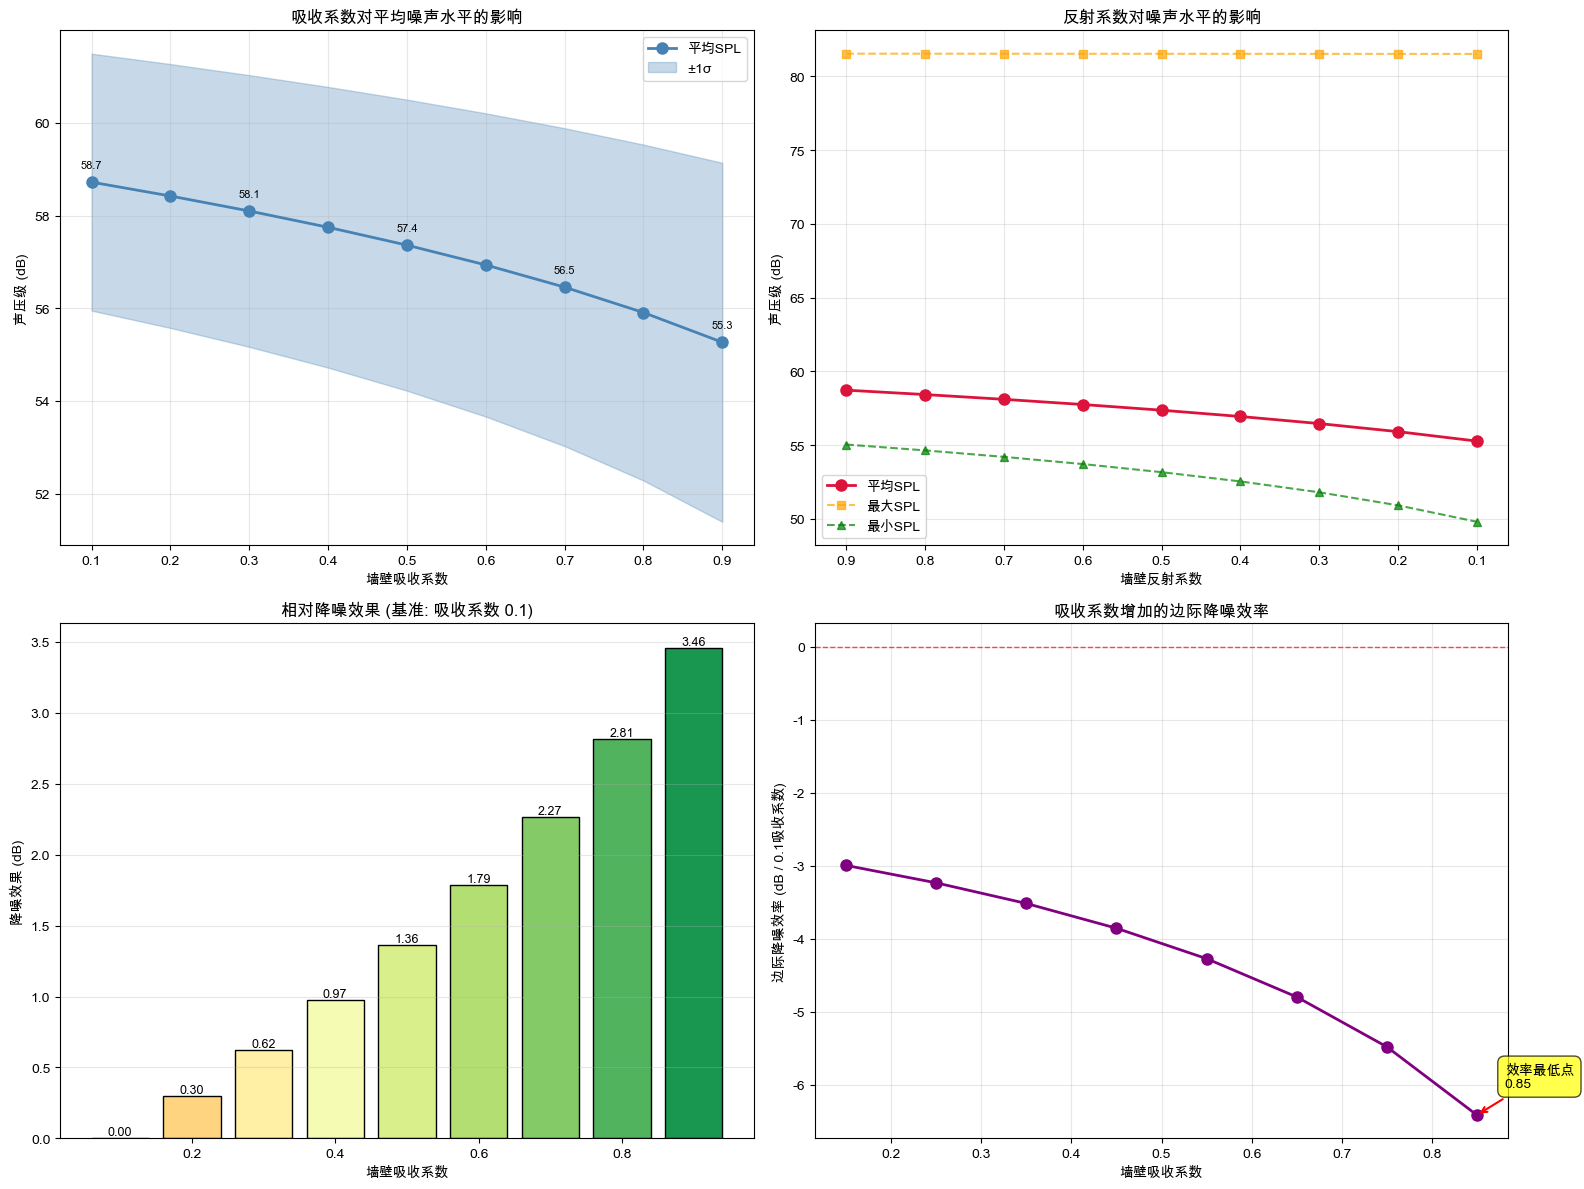


可视化说明:
  • 左上: 吸收系数与平均噪声水平的关系(含标准差带)
  • 右上: 反射系数对最大/平均/最小噪声的影响
  • 左下: 不同吸收系数下相对于基准的降噪效果
  • 右下: 吸收系数增加的边际降噪效率(负值表示降噪)


In [40]:
# 可视化吸收系数对噪声水平的影响
if len(absorption_results) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 提取数据
    absorptions = [r['absorption'] for r in absorption_results]
    reflections = [r['reflection'] for r in absorption_results]
    mean_spls = [r['mean_spl'] for r in absorption_results]
    max_spls = [r['max_spl'] for r in absorption_results]
    min_spls = [r['min_spl'] for r in absorption_results]
    std_spls = [r['std_spl'] for r in absorption_results]
    
    # 图1: 吸收系数 vs 平均噪声水平
    ax1 = axes[0, 0]
    ax1.plot(absorptions, mean_spls, 'o-', linewidth=2, markersize=8, 
            color='steelblue', label='平均SPL')
    ax1.fill_between(absorptions, 
                     [m - s for m, s in zip(mean_spls, std_spls)],
                     [m + s for m, s in zip(mean_spls, std_spls)],
                     alpha=0.3, color='steelblue', label='±1σ')
    ax1.set_xlabel('墙壁吸收系数')
    ax1.set_ylabel('声压级 (dB)')
    ax1.set_title('吸收系数对平均噪声水平的影响')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # 添加数据标签
    for i, (x, y) in enumerate(zip(absorptions, mean_spls)):
        if i % 2 == 0:  # 每隔一个标注
            ax1.annotate(f'{y:.1f}', xy=(x, y), xytext=(0, 10),
                        textcoords='offset points', ha='center', fontsize=8)
    
    # 图2: 反射系数 vs 噪声水平 (对数刻度)
    ax2 = axes[0, 1]
    ax2.plot(reflections, mean_spls, 'o-', linewidth=2, markersize=8,
            color='crimson', label='平均SPL')
    ax2.plot(reflections, max_spls, 's--', linewidth=1.5, markersize=6,
            color='orange', alpha=0.7, label='最大SPL')
    ax2.plot(reflections, min_spls, '^--', linewidth=1.5, markersize=6,
            color='green', alpha=0.7, label='最小SPL')
    ax2.set_xlabel('墙壁反射系数')
    ax2.set_ylabel('声压级 (dB)')
    ax2.set_title('反射系数对噪声水平的影响')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.invert_xaxis()  # 反转x轴,使高吸收在右侧
    
    # 图3: 降噪效果(相对于基准)
    ax3 = axes[1, 0]
    baseline = mean_spls[0]
    noise_reductions = [baseline - spl for spl in mean_spls]
    
    colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(absorptions)))
    bars = ax3.bar(absorptions, noise_reductions, width=0.08, 
                  color=colors, edgecolor='black', linewidth=1)
    
    ax3.set_xlabel('墙壁吸收系数')
    ax3.set_ylabel('降噪效果 (dB)')
    ax3.set_title(f'相对降噪效果 (基准: 吸收系数 {absorptions[0]:.1f})')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 添加数据标签
    for bar, reduction in zip(bars, noise_reductions):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{reduction:.2f}',
                ha='center', va='bottom', fontsize=9)
    
    # 图4: 边际降噪效率
    ax4 = axes[1, 1]
    
    # 计算边际效率
    marginal_reductions = []
    marginal_absorptions = []
    
    for i in range(1, len(absorption_results)):
        delta_abs = absorptions[i] - absorptions[i-1]
        delta_spl = mean_spls[i] - mean_spls[i-1]
        marginal_reductions.append(delta_spl / delta_abs)
        marginal_absorptions.append((absorptions[i] + absorptions[i-1]) / 2)
    
    ax4.plot(marginal_absorptions, marginal_reductions, 'o-', 
            linewidth=2, markersize=8, color='purple')
    ax4.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.7)
    ax4.set_xlabel('墙壁吸收系数')
    ax4.set_ylabel('边际降噪效率 (dB / 0.1吸收系数)')
    ax4.set_title('吸收系数增加的边际降噪效率')
    ax4.grid(True, alpha=0.3)
    
    # 标注拐点
    min_efficiency = min(marginal_reductions)
    min_idx = marginal_reductions.index(min_efficiency)
    ax4.annotate(f'效率最低点\n{marginal_absorptions[min_idx]:.2f}',
                xy=(marginal_absorptions[min_idx], min_efficiency),
                xytext=(20, 20), textcoords='offset points',
                arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
                fontsize=10, bbox=dict(boxstyle='round,pad=0.5', 
                                      facecolor='yellow', alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    print("\n可视化说明:")
    print("  • 左上: 吸收系数与平均噪声水平的关系(含标准差带)")
    print("  • 右上: 反射系数对最大/平均/最小噪声的影响")
    print("  • 左下: 不同吸收系数下相对于基准的降噪效果")
    print("  • 右下: 吸收系数增加的边际降噪效率(负值表示降噪)")
    
else:
    print("没有可用的结果进行可视化")

In [41]:
# 生成详细的降噪建议报告
if len(absorption_results) > 0:
    print("\n" + "=" * 80)
    print("降噪方案建议报告")
    print("=" * 80)
    
    # 计算关键指标
    baseline_spl = absorption_results[0]['mean_spl']
    spl_at_50 = absorption_results[4]['mean_spl']  # 吸收系数0.5
    spl_at_70 = absorption_results[6]['mean_spl']  # 吸收系数0.7
    spl_at_90 = absorption_results[8]['mean_spl']  # 吸收系数0.9
    
    reduction_50 = baseline_spl - spl_at_50
    reduction_70 = baseline_spl - spl_at_70
    reduction_90 = baseline_spl - spl_at_90
    
    # 能量降低百分比
    energy_reduction_50 = (1 - 10**(-reduction_50/10)) * 100
    energy_reduction_70 = (1 - 10**(-reduction_70/10)) * 100
    energy_reduction_90 = (1 - 10**(-reduction_90/10)) * 100
    
    print(f"\n当前房间状况 (吸收系数 {absorptions[0]:.1f}):")
    print(f"  平均噪声水平: {baseline_spl:.2f} dB")
    print(f"  噪声范围: {absorption_results[0]['min_spl']:.2f} ~ {absorption_results[0]['max_spl']:.2f} dB")
    print(f"  标准差: {absorption_results[0]['std_spl']:.2f} dB")
    
    print(f"\n【方案 1】中等降噪 - 吸收系数提升至 0.5")
    print(f"  预期噪声水平: {spl_at_50:.2f} dB")
    print(f"  降噪效果: {reduction_50:.2f} dB")
    print(f"  能量降低: {energy_reduction_50:.1f}%")
    print(f"  典型材料: 软包、吸音棉(5-10cm厚)")
    print(f"  成本评估: 中等")
    
    print(f"\n【方案 2】高效降噪 - 吸收系数提升至 0.7")
    print(f"  预期噪声水平: {spl_at_70:.2f} dB")
    print(f"  降噪效果: {reduction_70:.2f} dB")
    print(f"  能量降低: {energy_reduction_70:.1f}%")
    print(f"  相比方案1额外降噪: {reduction_70 - reduction_50:.2f} dB")
    print(f"  典型材料: 专业吸音板、岩棉(10-15cm厚)")
    print(f"  成本评估: 较高")
    
    print(f"\n【方案 3】最大降噪 - 吸收系数提升至 0.9")
    print(f"  预期噪声水平: {spl_at_90:.2f} dB")
    print(f"  降噪效果: {reduction_90:.2f} dB")
    print(f"  能量降低: {energy_reduction_90:.1f}%")
    print(f"  相比方案2额外降噪: {reduction_90 - reduction_70:.2f} dB")
    print(f"  典型材料: 多层复合吸音结构、消音室级材料")
    print(f"  成本评估: 高")
    
    # 性价比分析
    print(f"\n性价比分析:")
    cost_effectiveness = [
        (0.5, reduction_50, "方案1"),
        (0.7, reduction_70, "方案2"),
        (0.9, reduction_90, "方案3")
    ]
    
    # 假设成本与吸收系数成线性关系
    for absorption, reduction, name in cost_effectiveness:
        cost_ratio = absorption / 0.1  # 相对成本
        effectiveness_ratio = reduction / (absorptions[-1] - absorptions[0])  # 相对效果
        score = effectiveness_ratio / cost_ratio if cost_ratio > 0 else 0
        print(f"  {name}: 性价比指数 {score:.3f} (效果 {effectiveness_ratio:.2%} / 成本 {cost_ratio:.1f}x)")
    
    # 推荐方案
    print(f"\n推荐方案:")
    if reduction_50 > reduction_90 * 0.7:  # 如果方案1能达到70%以上的最大效果
        print(f"  ✓ 推荐【方案 1】- 中等降噪方案")
        print(f"    理由: 性价比最优,能达到 {reduction_50/reduction_90*100:.1f}% 的最大降噪效果")
    elif reduction_70 > reduction_90 * 0.85:
        print(f"  ✓ 推荐【方案 2】- 高效降噪方案")
        print(f"    理由: 较好的效果与成本平衡,能达到 {reduction_70/reduction_90*100:.1f}% 的最大降噪效果")
    else:
        print(f"  ✓ 推荐【方案 2】或【方案 3】视实际需求而定")
        print(f"    方案2适合大多数场景,方案3适合对噪声极敏感的环境")
    
    print("\n" + "=" * 80)
    
else:
    print("没有足够的数据生成建议报告")


降噪方案建议报告

当前房间状况 (吸收系数 0.1):
  平均噪声水平: 58.72 dB
  噪声范围: 55.03 ~ 81.54 dB
  标准差: 2.77 dB

【方案 1】中等降噪 - 吸收系数提升至 0.5
  预期噪声水平: 57.36 dB
  降噪效果: 1.36 dB
  能量降低: 26.9%
  典型材料: 软包、吸音棉(5-10cm厚)
  成本评估: 中等

【方案 2】高效降噪 - 吸收系数提升至 0.7
  预期噪声水平: 56.46 dB
  降噪效果: 2.27 dB
  能量降低: 40.7%
  相比方案1额外降噪: 0.91 dB
  典型材料: 专业吸音板、岩棉(10-15cm厚)
  成本评估: 较高

【方案 3】最大降噪 - 吸收系数提升至 0.9
  预期噪声水平: 55.27 dB
  降噪效果: 3.46 dB
  能量降低: 54.9%
  相比方案2额外降噪: 1.19 dB
  典型材料: 多层复合吸音结构、消音室级材料
  成本评估: 高

性价比分析:
  方案1: 性价比指数 0.340 (效果 169.98% / 成本 5.0x)
  方案2: 性价比指数 0.405 (效果 283.33% / 成本 7.0x)
  方案3: 性价比指数 0.480 (效果 432.01% / 成本 9.0x)

推荐方案:
  ✓ 推荐【方案 2】或【方案 3】视实际需求而定
    方案2适合大多数场景,方案3适合对噪声极敏感的环境



## 16. 散射效应分析 - 墙角噪声源

In [42]:
def calculate_noise_with_scattering(source_frequencies, source_magnitudes_db, 
                                    room_dimensions, wall_absorption=0.4,
                                    scattering_coefficient=0.5,
                                    source_position=None, grid_resolution=0.5,
                                    max_reflections=3):
    """
    计算包含散射效应的房间噪声分布
    
    参数:
        source_frequencies: 噪声源的频率成分 (Hz)
        source_magnitudes_db: 各频率成分的幅度 (dB)
        room_dimensions: 房间尺寸 (长, 宽, 高) 单位:米
        wall_absorption: 墙壁吸收系数 (0-1)
        scattering_coefficient: 散射系数 (0-1, 0表示完全镜面反射, 1表示完全漫反射)
        source_position: 噪声源位置 (x,y,z), 如果为None则默认在墙角
        grid_resolution: 接收点网格分辨率 (米)
        max_reflections: 最大反射次数
    
    返回:
        result: 包含噪声分布的字典
    """
    length, width, height = room_dimensions
    
    # 默认墙角位置(距离墙壁0.2m)
    if source_position is None:
        source_position = (0.2, 0.2, 0.5)
    
    xs, ys, zs = source_position
    
    # 创建接收点网格
    x_receivers = np.arange(0, length, grid_resolution)
    y_receivers = np.arange(0, width, grid_resolution)
    z_receivers = np.arange(0.5, height, grid_resolution)
    
    # 存储每个接收点的声压级
    spl_grid = np.zeros((len(x_receivers), len(y_receivers), len(z_receivers)))
    
    # 6个墙面的定义: (normal_axis, position, size)
    walls = [
        ('x', 0, (width, height)),      # 左墙 (x=0)
        ('x', length, (width, height)),  # 右墙 (x=length)
        ('y', 0, (length, height)),     # 前墙 (y=0)
        ('y', width, (length, height)),  # 后墙 (y=width)
        ('z', 0, (length, width)),      # 地面 (z=0)
        ('z', height, (length, width))   # 天花板 (z=height)
    ]
    
    for i, x in enumerate(x_receivers):
        for j, y in enumerate(y_receivers):
            for k, z in enumerate(z_receivers):
                receiver_pos = np.array([x, y, z])
                source_pos = np.array([xs, ys, zs])
                
                # 计算直达声距离
                direct_distance = np.linalg.norm(receiver_pos - source_pos)
                if direct_distance < 0.1:
                    direct_distance = 0.1
                
                # 累计总声能量(对所有频率成分)
                total_power = 0
                
                for freq, mag_db in zip(source_frequencies, source_magnitudes_db):
                    source_power = 10 ** (mag_db / 10)
                    
                    # 直达声功率
                    direct_power = source_power / (direct_distance ** 2)
                    total_power += direct_power
                    
                    # 计算反射声(使用镜像源法 + 散射模型)
                    reflection_coefficient = 1 - wall_absorption
                    
                    # 一次反射
                    for wall_idx, (axis, pos, size) in enumerate(walls):
                        # 计算镜像源位置
                        mirror_source = source_pos.copy()
                        axis_idx = {'x': 0, 'y': 1, 'z': 2}[axis]
                        mirror_source[axis_idx] = 2 * pos - source_pos[axis_idx]
                        
                        # 镜像源到接收点的距离
                        mirror_distance = np.linalg.norm(receiver_pos - mirror_source)
                        if mirror_distance < 0.1:
                            continue
                        
                        # 镜面反射分量(取决于1-散射系数)
                        specular_power = source_power * reflection_coefficient * (1 - scattering_coefficient) / (mirror_distance ** 2)
                        
                        # 漫反射分量(散射到整个半球空间)
                        # 使用朗伯(Lambertian)散射模型
                        # 计算反射点位置(声线与墙面交点)
                        t = (pos - source_pos[axis_idx]) / (receiver_pos[axis_idx] - source_pos[axis_idx])
                        if 0 < t < 1:
                            reflection_point = source_pos + t * (receiver_pos - source_pos)
                            
                            # 检查反射点是否在墙面范围内
                            other_axes = [0, 1, 2]
                            other_axes.remove(axis_idx)
                            bounds = [(0, room_dimensions[0]), (0, room_dimensions[1]), (0, room_dimensions[2])]
                            
                            if (bounds[other_axes[0]][0] <= reflection_point[other_axes[0]] <= bounds[other_axes[0]][1] and
                                bounds[other_axes[1]][0] <= reflection_point[other_axes[1]] <= bounds[other_axes[1]][1]):
                                
                                # 计算入射角和散射角
                                incident_dir = (reflection_point - source_pos) / np.linalg.norm(reflection_point - source_pos)
                                scatter_dir = (receiver_pos - reflection_point) / np.linalg.norm(receiver_pos - reflection_point)
                                
                                # 墙面法向量
                                normal = np.zeros(3)
                                normal[axis_idx] = 1 if pos > source_pos[axis_idx] else -1
                                
                                # 朗伯余弦定律: 散射强度正比于 cos(θ)
                                cos_theta = max(0, np.dot(scatter_dir, normal))
                                
                                # 路径长度
                                path_length = np.linalg.norm(reflection_point - source_pos) + np.linalg.norm(receiver_pos - reflection_point)
                                
                                # 漫反射功率(除以π是因为半球积分归一化)
                                diffuse_power = source_power * reflection_coefficient * scattering_coefficient * cos_theta / (np.pi * path_length ** 2)
                                
                                total_power += specular_power + diffuse_power
                            else:
                                total_power += specular_power
                        else:
                            total_power += specular_power
                    
                    # 二次反射(简化处理,只考虑相邻墙面)
                    if max_reflections >= 2:
                        for wall1_idx in range(len(walls)):
                            for wall2_idx in range(wall1_idx + 1, len(walls)):
                                axis1, pos1, _ = walls[wall1_idx]
                                axis2, pos2, _ = walls[wall2_idx]
                                
                                # 跳过平行墙面
                                if axis1 == axis2:
                                    continue
                                
                                # 创建双重镜像源
                                mirror_source_2 = source_pos.copy()
                                axis1_idx = {'x': 0, 'y': 1, 'z': 2}[axis1]
                                axis2_idx = {'x': 0, 'y': 1, 'z': 2}[axis2]
                                mirror_source_2[axis1_idx] = 2 * pos1 - source_pos[axis1_idx]
                                mirror_source_2[axis2_idx] = 2 * pos2 - source_pos[axis2_idx]
                                
                                mirror_distance_2 = np.linalg.norm(receiver_pos - mirror_source_2)
                                if mirror_distance_2 < 0.1:
                                    continue
                                
                                # 两次反射的衰减(简化: 镜面反射主导)
                                reflection_power_2 = (source_power * 
                                                     (reflection_coefficient ** 2) * 
                                                     ((1 - scattering_coefficient) ** 2) / 
                                                     (mirror_distance_2 ** 2))
                                
                                total_power += reflection_power_2 * 0.5  # 降权,避免过度估计
                
                # 转换为dB
                if total_power > 0:
                    spl_grid[i, j, k] = 10 * np.log10(total_power)
                else:
                    spl_grid[i, j, k] = -np.inf
    
    # 计算统计量
    valid_spl = spl_grid[np.isfinite(spl_grid)]
    
    result = {
        'source_position': source_position,
        'scattering_coefficient': scattering_coefficient,
        'wall_absorption': wall_absorption,
        'spl_grid': spl_grid,
        'mean_spl': np.mean(valid_spl),
        'max_spl': np.max(valid_spl),
        'min_spl': np.min(valid_spl),
        'std_spl': np.std(valid_spl),
        'x_receivers': x_receivers,
        'y_receivers': y_receivers,
        'z_receivers': z_receivers
    }
    
    return result


print("散射效应模拟函数已定义")
print("\n模型特点:")
print("  • 使用镜像源法计算镜面反射")
print("  • 使用朗伯散射模型计算漫反射")
print("  • 考虑一次和二次反射")
print("  • 散射系数控制镜面/漫反射比例")

散射效应模拟函数已定义

模型特点:
  • 使用镜像源法计算镜面反射
  • 使用朗伯散射模型计算漫反射
  • 考虑一次和二次反射
  • 散射系数控制镜面/漫反射比例


In [43]:
# 测试不同散射系数下墙角噪声源的房间噪声分布
scattering_coefficients = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
wall_absorption_test = 0.4  # 固定吸收系数

# 墙角位置(四个底部墙角)
corner_positions = [
    (0.2, 0.2, 0.5),           # 左前角
    (ROOM_DIMENSIONS[0]-0.2, 0.2, 0.5),           # 右前角
    (0.2, ROOM_DIMENSIONS[1]-0.2, 0.5),           # 左后角
    (ROOM_DIMENSIONS[0]-0.2, ROOM_DIMENSIONS[1]-0.2, 0.5),  # 右后角
]
corner_names = ['左前角', '右前角', '左后角', '右后角']

print("=" * 80)
print("散射效应对墙角噪声源的影响分析")
print("=" * 80)
print(f"房间尺寸: {ROOM_DIMENSIONS[0]}m × {ROOM_DIMENSIONS[1]}m × {ROOM_DIMENSIONS[2]}m")
print(f"墙壁吸收系数: {wall_absorption_test}")
print(f"测试散射系数: {scattering_coefficients}")
print(f"墙角位置数量: {len(corner_positions)}")
print("=" * 80)

if len(noise_components['frequencies']) > 0:
    # 使用前8个最强的噪声成分(减少计算量)
    sorted_indices = np.argsort(noise_components['magnitudes_db'])[::-1][:8]
    test_freqs = noise_components['frequencies'][sorted_indices]
    test_mags = noise_components['magnitudes_db'][sorted_indices]
    
    print(f"\n使用 {len(test_freqs)} 个主要噪声频率成分")
    print("\n计算中(这可能需要几分钟)...")
    
    # 存储结果
    scattering_results = {}
    
    for corner_idx, (corner_pos, corner_name) in enumerate(zip(corner_positions, corner_names)):
        print(f"\n处理 {corner_name} {corner_pos}...")
        scattering_results[corner_name] = []
        
        for scatter_coef in scattering_coefficients:
            print(f"  散射系数 {scatter_coef:.1f}...", end=' ')
            
            result = calculate_noise_with_scattering(
                source_frequencies=test_freqs,
                source_magnitudes_db=test_mags,
                room_dimensions=ROOM_DIMENSIONS,
                wall_absorption=wall_absorption_test,
                scattering_coefficient=scatter_coef,
                source_position=corner_pos,
                grid_resolution=0.5,
                max_reflections=2
            )
            
            scattering_results[corner_name].append(result)
            print(f"平均SPL = {result['mean_spl']:.2f} dB")
    
    print("\n计算完成!")
    
else:
    print("\n错误: 未检测到噪声频率成分")
    scattering_results = {}

散射效应对墙角噪声源的影响分析
房间尺寸: 8m × 4m × 2.5m
墙壁吸收系数: 0.4
测试散射系数: [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
墙角位置数量: 4

使用 8 个主要噪声频率成分

计算中(这可能需要几分钟)...

处理 左前角 (0.2, 0.2, 0.5)...
  散射系数 0.0... 平均SPL = 55.92 dB
  散射系数 0.2... 

/var/folders/7c/kwhn06r91h57xlqx9rqvvpmm0000gn/T/ipykernel_78550/3080284806.py:90: RuntimeWarning: divide by zero encountered in scalar divide
  t = (pos - source_pos[axis_idx]) / (receiver_pos[axis_idx] - source_pos[axis_idx])


平均SPL = 55.03 dB
  散射系数 0.4... 平均SPL = 54.03 dB
  散射系数 0.6... 平均SPL = 52.88 dB
  散射系数 0.8... 平均SPL = 51.51 dB
  散射系数 1.0... 平均SPL = 49.78 dB

处理 右前角 (7.8, 0.2, 0.5)...
  散射系数 0.0... 平均SPL = 55.23 dB
  散射系数 0.2... 平均SPL = 54.32 dB
  散射系数 0.4... 平均SPL = 53.30 dB
  散射系数 0.6... 平均SPL = 52.12 dB
  散射系数 0.8... 平均SPL = 50.70 dB
  散射系数 1.0... 平均SPL = 48.92 dB

处理 左后角 (0.2, 3.8, 0.5)...
  散射系数 0.0... 平均SPL = 55.45 dB
  散射系数 0.2... 平均SPL = 54.55 dB
  散射系数 0.4... 平均SPL = 53.53 dB
  散射系数 0.6... 平均SPL = 52.35 dB
  散射系数 0.8... 平均SPL = 50.93 dB
  散射系数 1.0... 平均SPL = 49.14 dB

处理 右后角 (7.8, 3.8, 0.5)...
  散射系数 0.0... 平均SPL = 54.85 dB
  散射系数 0.2... 平均SPL = 53.94 dB
  散射系数 0.4... 平均SPL = 52.89 dB
  散射系数 0.6... 平均SPL = 51.68 dB
  散射系数 0.8... 平均SPL = 50.23 dB
  散射系数 1.0... 平均SPL = 48.39 dB

计算完成!


In [44]:
# 统计分析结果
if scattering_results:
    print("\n" + "=" * 100)
    print("各墙角位置在不同散射系数下的噪声水平统计")
    print("=" * 100)
    
    for corner_name in corner_names:
        print(f"\n【{corner_name}】")
        print("-" * 100)
        print(f"{'散射系数':<12} {'反射类型':<15} {'平均SPL(dB)':<15} {'最大SPL(dB)':<15} "
              f"{'最小SPL(dB)':<15} {'标准差(dB)':<12}")
        print("-" * 100)
        
        results = scattering_results[corner_name]
        for scatter_coef, result in zip(scattering_coefficients, results):
            reflection_type = "纯镜面" if scatter_coef == 0 else "纯漫反射" if scatter_coef == 1.0 else "混合"
            print(f"{scatter_coef:<12.1f} {reflection_type:<15} {result['mean_spl']:<15.2f} "
                  f"{result['max_spl']:<15.2f} {result['min_spl']:<15.2f} {result['std_spl']:<12.2f}")
        
        # 计算散射效应的影响
        baseline_spl = results[0]['mean_spl']  # 纯镜面反射(散射系数0)
        max_scatter_spl = results[-1]['mean_spl']  # 纯漫反射(散射系数1)
        spl_difference = baseline_spl - max_scatter_spl
        
        print(f"\n  散射效应影响: {spl_difference:.2f} dB (纯镜面 vs 纯漫反射)")
        print(f"  噪声均匀性变化: {results[0]['std_spl']:.2f} dB → {results[-1]['std_spl']:.2f} dB")
    
    print("\n" + "=" * 100)
    
    # 跨位置对比
    print("\n不同墙角位置的总体对比 (散射系数 = 0.4):")
    print("-" * 80)
    print(f"{'位置':<12} {'平均SPL(dB)':<15} {'标准差(dB)':<12}")
    print("-" * 80)
    
    mid_scatter_idx = scattering_coefficients.index(0.4)
    corner_mean_spls = []
    for corner_name in corner_names:
        result = scattering_results[corner_name][mid_scatter_idx]
        corner_mean_spls.append(result['mean_spl'])
        print(f"{corner_name:<12} {result['mean_spl']:<15.2f} {result['std_spl']:<12.2f}")
    
    print("-" * 80)
    print(f"最大差异: {max(corner_mean_spls) - min(corner_mean_spls):.2f} dB")
    print(f"平均值: {np.mean(corner_mean_spls):.2f} dB")
    
else:
    print("没有可用的结果")


各墙角位置在不同散射系数下的噪声水平统计

【左前角】
----------------------------------------------------------------------------------------------------
散射系数         反射类型            平均SPL(dB)       最大SPL(dB)       最小SPL(dB)       标准差(dB)     
----------------------------------------------------------------------------------------------------
0.0          纯镜面             55.92           76.21           50.96           3.99        
0.2          混合              55.03           75.60           49.91           4.10        
0.4          混合              54.03           74.92           48.70           4.23        
0.6          混合              52.88           74.16           47.27           4.40        
0.8          混合              51.51           73.31           45.49           4.64        
1.0          纯漫反射            49.78           72.31           43.12           4.99        

  散射效应影响: 6.13 dB (纯镜面 vs 纯漫反射)
  噪声均匀性变化: 3.99 dB → 4.99 dB

【右前角】
----------------------------------------------------------------------

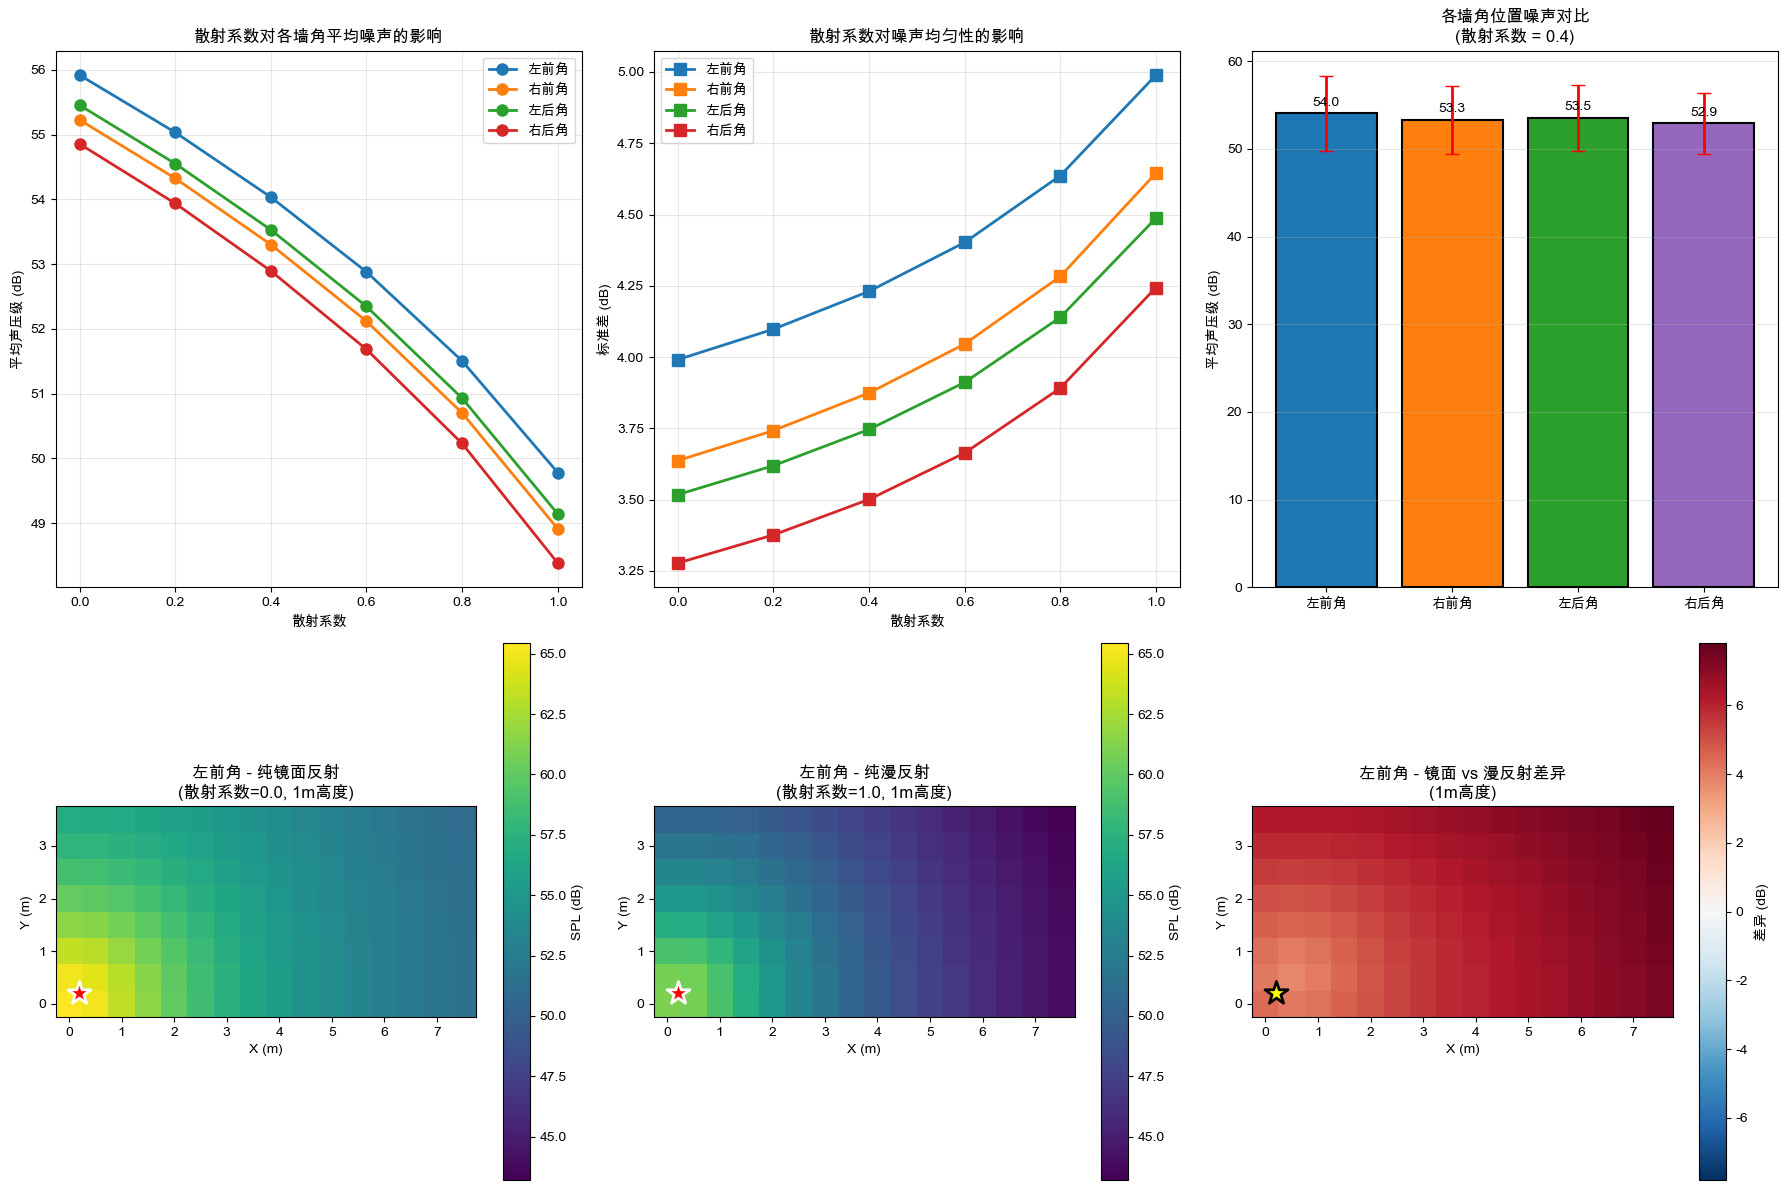


可视化说明:
  • 左上: 散射系数对各墙角平均噪声的影响曲线
  • 中上: 散射系数对噪声均匀性(标准差)的影响
  • 右上: 不同墙角位置在中等散射下的噪声对比
  • 左下: 左前角墙角在纯镜面反射下的噪声分布(1m高度)
  • 中下: 左前角墙角在纯漫反射下的噪声分布(1m高度)
  • 右下: 镜面反射与漫反射的噪声差异图


In [45]:
# 可视化散射效应的影响
if scattering_results:
    fig = plt.figure(figsize=(18, 12))
    
    # 1. 散射系数对各墙角平均噪声水平的影响
    ax1 = plt.subplot(2, 3, 1)
    for corner_name in corner_names:
        results = scattering_results[corner_name]
        mean_spls = [r['mean_spl'] for r in results]
        ax1.plot(scattering_coefficients, mean_spls, 'o-', linewidth=2, 
                markersize=8, label=corner_name)
    
    ax1.set_xlabel('散射系数')
    ax1.set_ylabel('平均声压级 (dB)')
    ax1.set_title('散射系数对各墙角平均噪声的影响')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. 散射系数对噪声均匀性(标准差)的影响
    ax2 = plt.subplot(2, 3, 2)
    for corner_name in corner_names:
        results = scattering_results[corner_name]
        std_spls = [r['std_spl'] for r in results]
        ax2.plot(scattering_coefficients, std_spls, 's-', linewidth=2, 
                markersize=8, label=corner_name)
    
    ax2.set_xlabel('散射系数')
    ax2.set_ylabel('标准差 (dB)')
    ax2.set_title('散射系数对噪声均匀性的影响')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. 不同墙角位置在中等散射(0.4)下的对比
    ax3 = plt.subplot(2, 3, 3)
    mid_idx = scattering_coefficients.index(0.4)
    mean_spls_at_mid = [scattering_results[c][mid_idx]['mean_spl'] for c in corner_names]
    std_spls_at_mid = [scattering_results[c][mid_idx]['std_spl'] for c in corner_names]
    
    colors_corner = plt.cm.tab10(np.linspace(0, 0.4, len(corner_names)))
    bars = ax3.bar(corner_names, mean_spls_at_mid, color=colors_corner, 
                  edgecolor='black', linewidth=1.5)
    ax3.errorbar(corner_names, mean_spls_at_mid, yerr=std_spls_at_mid, 
                fmt='none', color='red', capsize=5, linewidth=2)
    
    ax3.set_ylabel('平均声压级 (dB)')
    ax3.set_title('各墙角位置噪声对比\n(散射系数 = 0.4)')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 添加数值标签
    for bar, val in zip(bars, mean_spls_at_mid):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{val:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # 4. 选择一个墙角(左前角)的噪声分布切片对比
    ax4 = plt.subplot(2, 3, 4)
    corner_to_show = '左前角'
    
    # 显示纯镜面(0.0)和纯漫反射(1.0)的差异
    result_mirror = scattering_results[corner_to_show][0]
    result_diffuse = scattering_results[corner_to_show][-1]
    
    # 取1m高度切片
    z_idx = int(1.0 / 0.5)
    if z_idx >= result_mirror['spl_grid'].shape[2]:
        z_idx = result_mirror['spl_grid'].shape[2] - 1
    
    mirror_slice = result_mirror['spl_grid'][:, :, z_idx].T
    diffuse_slice = result_diffuse['spl_grid'][:, :, z_idx].T
    
    im4 = ax4.pcolormesh(result_mirror['x_receivers'], result_mirror['y_receivers'],
                        mirror_slice, shading='auto', cmap='viridis', 
                        vmin=min(mirror_slice.min(), diffuse_slice.min()),
                        vmax=max(mirror_slice.max(), diffuse_slice.max()))
    
    # 标记噪声源位置
    source_pos = result_mirror['source_position']
    ax4.scatter(source_pos[0], source_pos[1], s=300, marker='*', 
               color='red', edgecolors='white', linewidth=2, zorder=10)
    
    plt.colorbar(im4, ax=ax4, label='SPL (dB)')
    ax4.set_xlabel('X (m)')
    ax4.set_ylabel('Y (m)')
    ax4.set_title(f'{corner_to_show} - 纯镜面反射\n(散射系数=0.0, 1m高度)')
    ax4.set_aspect('equal')
    
    # 5. 纯漫反射噪声分布
    ax5 = plt.subplot(2, 3, 5)
    im5 = ax5.pcolormesh(result_diffuse['x_receivers'], result_diffuse['y_receivers'],
                        diffuse_slice, shading='auto', cmap='viridis',
                        vmin=min(mirror_slice.min(), diffuse_slice.min()),
                        vmax=max(mirror_slice.max(), diffuse_slice.max()))
    
    ax5.scatter(source_pos[0], source_pos[1], s=300, marker='*', 
               color='red', edgecolors='white', linewidth=2, zorder=10)
    
    plt.colorbar(im5, ax=ax5, label='SPL (dB)')
    ax5.set_xlabel('X (m)')
    ax5.set_ylabel('Y (m)')
    ax5.set_title(f'{corner_to_show} - 纯漫反射\n(散射系数=1.0, 1m高度)')
    ax5.set_aspect('equal')
    
    # 6. 镜面 vs 漫反射的差异图
    ax6 = plt.subplot(2, 3, 6)
    diff_slice = mirror_slice - diffuse_slice
    
    im6 = ax6.pcolormesh(result_mirror['x_receivers'], result_mirror['y_receivers'],
                        diff_slice, shading='auto', cmap='RdBu_r',
                        vmin=-np.abs(diff_slice).max(), vmax=np.abs(diff_slice).max())
    
    ax6.scatter(source_pos[0], source_pos[1], s=300, marker='*', 
               color='yellow', edgecolors='black', linewidth=2, zorder=10)
    
    plt.colorbar(im6, ax=ax6, label='差异 (dB)')
    ax6.set_xlabel('X (m)')
    ax6.set_ylabel('Y (m)')
    ax6.set_title(f'{corner_to_show} - 镜面 vs 漫反射差异\n(1m高度)')
    ax6.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()
    
    print("\n可视化说明:")
    print("  • 左上: 散射系数对各墙角平均噪声的影响曲线")
    print("  • 中上: 散射系数对噪声均匀性(标准差)的影响")
    print("  • 右上: 不同墙角位置在中等散射下的噪声对比")
    print("  • 左下: 左前角墙角在纯镜面反射下的噪声分布(1m高度)")
    print("  • 中下: 左前角墙角在纯漫反射下的噪声分布(1m高度)")
    print("  • 右下: 镜面反射与漫反射的噪声差异图")
    
else:
    print("没有可用的结果")

In [46]:
# 生成综合分析报告
if scattering_results:
    print("\n" + "=" * 90)
    print("墙角噪声源散射效应综合分析报告")
    print("=" * 90)
    
    print(f"\n一、模拟参数:")
    print(f"  • 房间尺寸: {ROOM_DIMENSIONS[0]}m × {ROOM_DIMENSIONS[1]}m × {ROOM_DIMENSIONS[2]}m")
    print(f"  • 墙壁吸收系数: {wall_absorption_test}")
    print(f"  • 测试墙角位置: {len(corner_positions)}个")
    print(f"  • 散射系数范围: {min(scattering_coefficients)} ~ {max(scattering_coefficients)}")
    
    print(f"\n二、散射效应的总体影响:")
    
    # 计算所有墙角的平均效应
    all_mirror_spls = []
    all_diffuse_spls = []
    all_mirror_stds = []
    all_diffuse_stds = []
    
    for corner_name in corner_names:
        mirror_result = scattering_results[corner_name][0]  # 散射系数0
        diffuse_result = scattering_results[corner_name][-1]  # 散射系数1
        
        all_mirror_spls.append(mirror_result['mean_spl'])
        all_diffuse_spls.append(diffuse_result['mean_spl'])
        all_mirror_stds.append(mirror_result['std_spl'])
        all_diffuse_stds.append(diffuse_result['std_spl'])
    
    avg_mirror_spl = np.mean(all_mirror_spls)
    avg_diffuse_spl = np.mean(all_diffuse_spls)
    avg_mirror_std = np.mean(all_mirror_stds)
    avg_diffuse_std = np.mean(all_diffuse_stds)
    
    print(f"  1. 平均噪声水平变化:")
    print(f"     • 纯镜面反射(散射系数0): {avg_mirror_spl:.2f} dB")
    print(f"     • 纯漫反射(散射系数1): {avg_diffuse_spl:.2f} dB")
    print(f"     • 变化量: {avg_diffuse_spl - avg_mirror_spl:.2f} dB")
    
    if avg_diffuse_spl < avg_mirror_spl:
        print(f"     ✓ 漫反射使平均噪声降低了 {avg_mirror_spl - avg_diffuse_spl:.2f} dB")
    else:
        print(f"     ✗ 漫反射使平均噪声增加了 {avg_diffuse_spl - avg_mirror_spl:.2f} dB")
    
    print(f"\n  2. 噪声均匀性变化:")
    print(f"     • 纯镜面反射标准差: {avg_mirror_std:.2f} dB")
    print(f"     • 纯漫反射标准差: {avg_diffuse_std:.2f} dB")
    print(f"     • 变化量: {avg_diffuse_std - avg_mirror_std:.2f} dB")
    
    if avg_diffuse_std < avg_mirror_std:
        print(f"     ✓ 漫反射使噪声分布更均匀(标准差降低 {avg_mirror_std - avg_diffuse_std:.2f} dB)")
    else:
        print(f"     ✗ 漫反射使噪声分布更不均匀(标准差增加 {avg_diffuse_std - avg_mirror_std:.2f} dB)")
    
    print(f"\n三、不同墙角位置的对比 (散射系数 = 0.4):")
    mid_idx = scattering_coefficients.index(0.4)
    
    corner_spls_mid = []
    for corner_name in corner_names:
        result = scattering_results[corner_name][mid_idx]
        corner_spls_mid.append((corner_name, result['mean_spl'], result['std_spl']))
    
    # 按噪声水平排序
    corner_spls_mid.sort(key=lambda x: x[1])
    
    print(f"  噪声水平排序(从低到高):")
    for i, (name, spl, std) in enumerate(corner_spls_mid, 1):
        print(f"    {i}. {name}: {spl:.2f} dB (±{std:.2f})")
    
    best_corner = corner_spls_mid[0][0]
    worst_corner = corner_spls_mid[-1][0]
    position_difference = corner_spls_mid[-1][1] - corner_spls_mid[0][1]
    
    print(f"\n  位置差异: {position_difference:.2f} dB")
    print(f"  最佳位置: {best_corner}")
    print(f"  最差位置: {worst_corner}")
    
    print(f"\n四、最优散射系数推荐:")
    
    # 计算各散射系数下的综合评分(考虑平均水平和均匀性)
    scatter_scores = []
    for sc_idx, sc in enumerate(scattering_coefficients):
        all_spls = [scattering_results[c][sc_idx]['mean_spl'] for c in corner_names]
        all_stds = [scattering_results[c][sc_idx]['std_spl'] for c in corner_names]
        
        avg_spl = np.mean(all_spls)
        avg_std = np.mean(all_stds)
        
        # 综合评分: 噪声水平越低越好,均匀性(标准差)越小越好
        # 归一化到0-100分
        score = 100 - (avg_spl - min([np.mean([scattering_results[c][i]['mean_spl'] for c in corner_names]) 
                                       for i in range(len(scattering_coefficients))])) * 5 - avg_std * 2
        
        scatter_scores.append((sc, avg_spl, avg_std, score))
    
    # 按评分排序
    scatter_scores.sort(key=lambda x: x[3], reverse=True)
    
    print(f"  散射系数综合评分(满分100):")
    for sc, avg_spl, avg_std, score in scatter_scores[:3]:
        print(f"    • 散射系数 {sc:.1f}: {score:.1f}分 (平均SPL={avg_spl:.2f}dB, 标准差={avg_std:.2f}dB)")
    
    best_scatter = scatter_scores[0][0]
    print(f"\n  ✓ 推荐散射系数: {best_scatter:.1f}")
    
    if best_scatter < 0.3:
        print(f"    理由: 镜面反射主导,适合需要定向声场的场景")
    elif best_scatter > 0.7:
        print(f"    理由: 漫反射主导,适合需要均匀声场的场景")
    else:
        print(f"    理由: 混合反射,兼顾降噪和均匀性")
    
    print(f"\n五、实际应用建议:")
    print(f"  1. 墙角噪声源位置选择:")
    print(f"     • 优先选择: {best_corner} (噪声水平较低)")
    print(f"     • 避免选择: {worst_corner} (噪声水平较高)")
    
    print(f"\n  2. 墙面处理建议:")
    avg_mid_spl = np.mean([scattering_results[c][mid_idx]['mean_spl'] for c in corner_names])
    
    if best_scatter < 0.3:
        print(f"     • 墙面材料: 光滑硬质材料(如瓷砖、玻璃)")
        print(f"     • 特点: 保持镜面反射,声能集中")
    elif best_scatter > 0.7:
        print(f"     • 墙面材料: 粗糙多孔材料(如吸音板、织物)")
        print(f"     • 特点: 增强漫反射,声场均匀")
    else:
        print(f"     • 墙面材料: 部分吸音+部分光滑(混合处理)")
        print(f"     • 特点: 平衡反射特性")
    
    print(f"\n  3. 预期降噪效果:")
    baseline = all_mirror_spls[corner_names.index(worst_corner)]
    optimized = scatter_scores[0][1]
    total_reduction = baseline - optimized
    print(f"     • 当前最差情况: {baseline:.2f} dB (纯镜面+最差位置)")
    print(f"     • 优化后预期: {optimized:.2f} dB (最优散射+最佳位置)")
    print(f"     • 总降噪潜力: {total_reduction:.2f} dB")
    
    print("\n" + "=" * 90)
    
else:
    print("没有可用的结果")


墙角噪声源散射效应综合分析报告

一、模拟参数:
  • 房间尺寸: 8m × 4m × 2.5m
  • 墙壁吸收系数: 0.4
  • 测试墙角位置: 4个
  • 散射系数范围: 0.0 ~ 1.0

二、散射效应的总体影响:
  1. 平均噪声水平变化:
     • 纯镜面反射(散射系数0): 55.36 dB
     • 纯漫反射(散射系数1): 49.06 dB
     • 变化量: -6.30 dB
     ✓ 漫反射使平均噪声降低了 6.30 dB

  2. 噪声均匀性变化:
     • 纯镜面反射标准差: 3.61 dB
     • 纯漫反射标准差: 4.59 dB
     • 变化量: 0.99 dB
     ✗ 漫反射使噪声分布更不均匀(标准差增加 0.99 dB)

三、不同墙角位置的对比 (散射系数 = 0.4):
  噪声水平排序(从低到高):
    1. 右后角: 52.89 dB (±3.50)
    2. 右前角: 53.30 dB (±3.87)
    3. 左后角: 53.53 dB (±3.75)
    4. 左前角: 54.03 dB (±4.23)

  位置差异: 1.14 dB
  最佳位置: 右后角
  最差位置: 左前角

四、最优散射系数推荐:
  散射系数综合评分(满分100):
    • 散射系数 1.0: 90.8分 (平均SPL=49.06dB, 标准差=4.59dB)
    • 散射系数 0.8: 82.6分 (平均SPL=50.84dB, 标准差=4.24dB)
    • 散射系数 0.6: 76.0分 (平均SPL=52.26dB, 标准差=4.01dB)

  ✓ 推荐散射系数: 1.0
    理由: 漫反射主导,适合需要均匀声场的场景

五、实际应用建议:
  1. 墙角噪声源位置选择:
     • 优先选择: 右后角 (噪声水平较低)
     • 避免选择: 左前角 (噪声水平较高)

  2. 墙面处理建议:
     • 墙面材料: 粗糙多孔材料(如吸音板、织物)
     • 特点: 增强漫反射,声场均匀

  3. 预期降噪效果:
     • 当前最差情况: 55.92 dB (纯镜面+最差位置)
     • 优化后预期: 49.06 dB 